## TITLE: TELCO CHURN CLASSIFICATION PROJECT

In [1]:
# Importing all the necessary Libraries

import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import mannwhitneyu
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Suppressing all warnings
from warnings import filterwarnings
filterwarnings('ignore')

### Create a connection using SQL Alchemy

In [2]:
'''# Importing necessary packages from sql alchemy
import sqlalchemy as sa
from sqlalchemy import create_engine, text
from sqlalchemy import inspect

# Database credentials
host="dap-projects-database.database.windows.net"
username ="LP1_learner"
password ="Hyp0th3s!$T3$t!ng"
database_name ="dapDB"

# Setting up connection strings
conn_str = f"mssql+pyodbc://{username}:{password}@{host}/{database_name}?driver=ODBC+Driver+18+for+SQL+Server"

# Creaing database engine
engine = sa.create_engine(conn_str)

# Verifying
engine'''

'# Importing necessary packages from sql alchemy\nimport sqlalchemy as sa\nfrom sqlalchemy import create_engine, text\nfrom sqlalchemy import inspect\n\n# Database credentials\nhost="dap-projects-database.database.windows.net"\nusername ="LP1_learner"\npassword ="Hyp0th3s!$T3$t!ng"\ndatabase_name ="dapDB"\n\n# Setting up connection strings\nconn_str = f"mssql+pyodbc://{username}:{password}@{host}/{database_name}?driver=ODBC+Driver+18+for+SQL+Server"\n\n# Creaing database engine\nengine = sa.create_engine(conn_str)\n\n# Verifying\nengine'

### Using 'Inspect' package to identify tables from the remote host

In [3]:
'''# Inspecting the database engine, retrieve a list of table names from the 'dbo' schema, and print the list of tables
t=inspect(engine)

tables=t.get_table_names(schema='dbo')
print("tables in dbo:", tables)'''

'# Inspecting the database engine, retrieve a list of table names from the \'dbo\' schema, and print the list of tables\nt=inspect(engine)\n\ntables=t.get_table_names(schema=\'dbo\')\nprint("tables in dbo:", tables)'

### Application of pandas to display dataframes for all data

In [4]:
# ----------------------------------------------------------------------
# Load the Telco churn first dataset into a pandas DataFrame and assigning train1 as a variable name
# ----------------------------------------------------------------------
train1 = pd.read_csv(r"C:\Users\PRINCE\Downloads\Telco-churn-first-3000.csv")

# ----------------------------------------------------------------------
# Display the first few rows of the DataFrame
# ----------------------------------------------------------------------
train1.head()
# ----------------------------------------------------------------------
# TODO: Explore the data
# ----------------------------------------------------------------------

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [5]:
# ----------------------------------------------------------------------
# Load the second Telco churn dataset into a pandas DataFrame and assigning train2 as a variable name
# ----------------------------------------------------------------------
train2 = pd.read_csv(r"C:\Users\PRINCE\Downloads\LP2_Telco-churn-second-2000.csv")

# ----------------------------------------------------------------------
# Display the first few rows of the second DataFrame
# ----------------------------------------------------------------------
train2.head()  # TODO: Compare with train1

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [6]:
# Test data
# ----------------------------------------------------------------------
# Load the Telco churn test data from Excel file into a pandas DataFrame and assigning test_data as a variable name
# ----------------------------------------------------------------------
test_data = pd.read_excel(r"C:\Users\PRINCE\Downloads\Telco-churn-last-2000.xlsx")

# ----------------------------------------------------------------------
# Display the first few rows of the test data
# ----------------------------------------------------------------------
test_data.head()  # TODO: Verify data integrity

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## DATA UNDERSTANDING

### Dataset Exploration

#### Exploring the 2 training dataset

In [7]:
# ----------------------------------------------------------------------
# Get the shape of the first training dataset (rows, columns)
# ----------------------------------------------------------------------
train1_shape = train1.shape

train1_shape  # Output: (number of rows, number of columns)

(3000, 21)

In [8]:
# ----------------------------------------------------------------------
# Display concise summary of the first training dataset
# ----------------------------------------------------------------------
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [9]:
# ----------------------------------------------------------------------
# Generate descriptive statistics for the first training dataset
# ----------------------------------------------------------------------
train1.describe()

,tenure,MonthlyCharges,TotalCharges
count,3000.000000,3000.000000,2995.000000
mean,32.527333,65.347400,2301.278315
std,24.637768,30.137053,2274.987884
min,0.000000,18.400000,18.799999
25%,9.000000,35.787499,415.250000
50%,29.000000,70.900002,1404.650024
75%,56.000000,90.262501,3868.725098
max,72.000000,118.650002,8564.750000


In [10]:
# ----------------------------------------------------------------------
# Check for duplicate rows in the first training dataset
# ----------------------------------------------------------------------
duplicate_count = train1.duplicated().sum()

print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [11]:
# ----------------------------------------------------------------------
# Count missing values in each column of the first training dataset
# ----------------------------------------------------------------------
missing_values = train1.isnull().sum()
missing_values

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [12]:
# ----------------------------------------------------------------------
# Get the shape of the second training dataset (rows, columns)
# ----------------------------------------------------------------------
train2_shape = train2.shape

print(train2_shape)  # Output: (number of rows, number of columns)

(2043, 21)


In [13]:
# ----------------------------------------------------------------------
# Display concise summary of the second training dataset
# ----------------------------------------------------------------------
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [14]:
# ----------------------------------------------------------------------
# Generate descriptive statistics for the second training dataset
# ----------------------------------------------------------------------
train2.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,2043.000000,2043.000000,2043.000000
mean,0.168380,32.649046,64.712555
std,0.374295,24.376248,29.970010
min,0.000000,0.000000,18.550000
25%,0.000000,9.000000,35.825000
50%,0.000000,30.000000,70.250000
75%,0.000000,55.000000,89.625000
max,1.000000,72.000000,118.350000


In [15]:
# ----------------------------------------------------------------------
# Count duplicate rows in the second training dataset
# ----------------------------------------------------------------------
duplicate_count = train2.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [16]:
# ----------------------------------------------------------------------
# Count missing values in each column of the second training dataset
# ----------------------------------------------------------------------
missing_values = train2.isnull().sum()
missing_values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

####  Exploring test dataset

In [17]:
# ----------------------------------------------------------------------
# Get the shape of the test dataset (rows, columns)
# ----------------------------------------------------------------------
test_data_shape = test_data.shape

test_data_shape  # Output: (number of rows, number of columns)

(2000, 20)

In [18]:
# ----------------------------------------------------------------------
# Display concise summary of the test dataset
# ----------------------------------------------------------------------
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [19]:
# ----------------------------------------------------------------------
# Generate descriptive statistics for the test dataset
# ----------------------------------------------------------------------
test_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,2000.000000,2000.000000,2000.000000
mean,0.161500,31.853000,63.933325
std,0.368084,24.632677,30.136858
min,0.000000,0.000000,18.250000
25%,0.000000,8.000000,34.250000
50%,0.000000,27.000000,69.800000
75%,0.000000,55.000000,89.275000
max,1.000000,72.000000,118.750000


In [20]:
# ----------------------------------------------------------------------
# Count duplicate rows in the test dataset
# ----------------------------------------------------------------------
duplicate_count = test_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [21]:
# ----------------------------------------------------------------------
# Count missing values in each column of the test dataset
# ----------------------------------------------------------------------
missing_values = test_data.isnull().sum()
print(missing_values)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


### Concatenate train1 & train2

In [22]:
# ----------------------------------------------------------------------
# Concatenate train1 and train2 DataFrames into a single DataFrame
# ----------------------------------------------------------------------
train_data = pd.concat([train1, train2], ignore_index=True)

In [23]:
# ----------------------------------------------------------------------
# Get the shape of the concatenated training dataset
# ----------------------------------------------------------------------
rows, cols = train_data.shape
print(f"Rows: {rows}, Columns: {cols}")

Rows: 5043, Columns: 21


In [24]:
# ----------------------------------------------------------------------
# Display concise summary of the concatenated training dataset
# ----------------------------------------------------------------------
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [25]:
# ----------------------------------------------------------------------
# Generate descriptive statistics for the concatenated training dataset
# ----------------------------------------------------------------------
train_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5043.000000,5043.000000,5043.000000
mean,0.162403,32.576641,65.090214
std,0.368857,24.529807,30.068133
min,0.000000,0.000000,18.400000
25%,0.000000,9.000000,35.775000
50%,0.000000,29.000000,70.550003
75%,0.000000,56.000000,90.050003
max,1.000000,72.000000,118.650002


In [26]:
# ----------------------------------------------------------------------
# Count duplicate rows in the concatenated training dataset
# ----------------------------------------------------------------------
duplicate_count = train_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


In [27]:
# ----------------------------------------------------------------------
# Count missing values in each column of the concatenated training dataset
# ----------------------------------------------------------------------
missing_values = train_data.isna().sum()
print(missing_values)

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


In [28]:
# ----------------------------------------------------------------------
# Convert 'TotalCharges' column to numeric values in training and testing datasets
# ----------------------------------------------------------------------
train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors='coerce')
test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors='coerce')

In [29]:
# Verifying
# ----------------------------------------------------------------------
# Display data type of 'TotalCharges' column
# ----------------------------------------------------------------------
print(train_data['TotalCharges'].dtype)
print(test_data['TotalCharges'].dtype)

float64
float64


In [30]:
# ----------------------------------------------------------------------
# Calculate percentage of missing values in training data
# ----------------------------------------------------------------------
missing_value_percent = train_data.isnull().mean() * 100
print(missing_value_percent)

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        5.334127
InternetService      0.000000
OnlineSecurity      12.908983
OnlineBackup        12.908983
DeviceProtection    12.908983
TechSupport         12.908983
StreamingTV         12.908983
StreamingMovies     12.908983
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.158636
Churn                0.019829
dtype: float64


### Observation

* Imputing those with significant percentages of missing values
* Dropping the ones with lesser percentages of missing values
* Checking for outliers and make sure to standardize if necessary

In [31]:
# --------------------------------------------------------
# Define function to calculate unique values
# --------------------------------------------------------
def unique_values(dataframe):
    """
    Calculate unique values and their counts for each column in a DataFrame.

    Args:
        - dataframe (pd.DataFrame): Input DataFrame.

    Returns:
        - usummary (pd.DataFrame): DataFrame containing unique values and counts.
    """
    # Initialize empty list to store unique value summaries
    unique_summary = []

    # Iterate through each column in the DataFrame
    for column in dataframe.columns:
        # Calculate unique values
        values = dataframe[column].unique()
        
        # Count unique values
        counts_values = len(values)
        
        # Append results to the summary list
        unique_summary.append({
            "Column": column,
            "Unique_Values": values,
            "Count_of_Unique_Values": counts_values
        })
    
    # Convert summary list to DataFrame
    usummary = pd.DataFrame(unique_summary)
    
    # Return the summary DataFrame
    return usummary
    
    # Calculate unique values
    unique_summary = unique_values(df)
    
    # Display results
    print(unique_summary)

In [32]:
# ----------------------------------------------------------------------
# Calculate unique values in train data
# ----------------------------------------------------------------------
unique_summary = unique_values(train_data)

# ----------------------------------------------------------------------
# Display results
# ----------------------------------------------------------------------
unique_summary

,Column,Unique_Values,Count_of_Unique_Values
0,customerID,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",5043
1,gender,"[Female, Male]",2
2,SeniorCitizen,"[0, 1]",2
3,Partner,"[True, False, No, Yes]",4
4,Dependents,"[False, True, No, Yes]",4
5,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
6,PhoneService,"[False, True, Yes, No]",4
7,MultipleLines,"[nan, False, True, No, No phone service, Yes]",6
8,InternetService,"[DSL, Fiber optic, No]",3
9,OnlineSecurity,"[False, True, nan, No, Yes, No internet service]",6


In [33]:
# ----------------------------------------------------------------------
# Drop 'customerID' column from training and testing datasets
# ----------------------------------------------------------------------
train_data.drop(columns="customerID", inplace=True)
test_data.drop(columns="customerID", inplace=True)

In [34]:
# ----------------------------------------------------------------------
# Display first few rows of training data
# ----------------------------------------------------------------------
train_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,True,False,1,False,NaN,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,Male,0,False,False,45,False,NaN,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [35]:
# ----------------------------------------------------------------------
# Convert SeniorCitizen column data type from interger to object
# ----------------------------------------------------------------------
train_data['SeniorCitizen'] = train_data['SeniorCitizen'].astype(object)
train_data['SeniorCitizen'] 

0       0
1       0
2       0
3       0
4       0
       ..
5038    0
5039    0
5040    0
5041    1
5042    0
Name: SeniorCitizen, Length: 5043, dtype: object

In [36]:
# ----------------------------------------------------------------------
# Select object-type columns (categorical variables)
# ----------------------------------------------------------------------
labels = train_data.select_dtypes(include="object").columns.tolist()
print(labels)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [37]:
# ----------------------------------------------------------------------
# Convert to strings
# ----------------------------------------------------------------------
train_data[labels] = train_data[labels].astype(str)

In [38]:
# Adding a function to make the necessary changes

# ----------------------------------------------------------------------
# Define binary correction dictionary
# ----------------------------------------------------------------------
binary = {
    "No": ["False", "0", "No phone service", "No internet service"],
    "Yes": ["True", "1"]
}

# ----------------------------------------------------------------------
# Correct binary columns
# ----------------------------------------------------------------------
def correct_columns(train_data, labels, binary):
    """
    Correct binary values in specified columns.

    Args:
        - train_data (pd.DataFrame): Input DataFrame.
        - labels (list): Column names to correct.
        - binary (dict): Binary correction dictionary.

    Returns:
        - train_data (pd.DataFrame): Corrected DataFrame.
    """
    for column_name in labels:
        for key, values in binary.items():
            train_data[column_name] = train_data[column_name].replace(values, key)
    return train_data

# ----------------------------------------------------------------------
# Apply corrections
# ----------------------------------------------------------------------
train_data = correct_columns(train_data, labels, binary)

In [39]:
# ----------------------------------------------------------------------
# Verifying
# ----------------------------------------------------------------------
unique_values(train_data)

,Column,Unique_Values,Count_of_Unique_Values
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
5,PhoneService,"[No, Yes]",2
6,MultipleLines,"[nan, No, Yes]",3
7,InternetService,"[DSL, Fiber optic, No]",3
8,OnlineSecurity,"[No, Yes, nan]",3
9,OnlineBackup,"[Yes, No, nan]",3


In [40]:
# ----------------------------------------------------------------------
# Change column names for gender and tenure
# ----------------------------------------------------------------------
train_data.rename(columns={"gender": "Gender", "tenure": "Tenure"}, inplace=True)

In [41]:
# ----------------------------------------------------------------------
# Select numerical columns
# ----------------------------------------------------------------------
numbers = train_data[["Tenure", "MonthlyCharges", "TotalCharges"]]

# ----------------------------------------------------------------------
# Display numerical columns
# ----------------------------------------------------------------------
numbers

,Tenure,MonthlyCharges,TotalCharges
0,1,29.850000,29.850000
1,34,56.950001,1889.500000
2,2,53.849998,108.150002
3,45,42.299999,1840.750000
4,2,70.699997,151.649994
...,...,...,...
5038,24,84.800000,1990.500000
5039,72,103.200000,7362.900000
5040,11,29.600000,346.450000
5041,4,74.400000,306.600000


### Imputing the missing values

In [42]:
# ---------------------------------------------------------------------- 
# Filling numerical - TotalCharges 
# ---------------------------------------------------------------------- 
train_data["TotalCharges"] = train_data["TotalCharges"].fillna((train_data["TotalCharges"].median()))

# ---------------------------------------------------------------------- 
# Selecting categorical columns with missing values 
# ---------------------------------------------------------------------- 
cat_cols = ["MultipleLines", "OnlineSecurity", "OnlineBackup", 
            "DeviceProtection", "TechSupport", "StreamingTV", 
            "StreamingMovies", "Churn"]

for col in cat_cols:
    # Replace empty strings and string NaN with NaN
    train_data[col] = train_data[col].replace(["", "NaN", "nan"], np.nan)
    
    # Fill NaN with mode, handling the case where mode returns 0
    mode_value = train_data[col].mode().iloc[0]
    train_data[col] = train_data[col].fillna(mode_value)

In [43]:
# ----------------------------------------------------------------------
# Verifying
# ----------------------------------------------------------------------
for col in cat_cols:
    print(f"Unique values in {col}:{train_data[col].unique()}")

Unique values in MultipleLines:['No' 'Yes']
Unique values in OnlineSecurity:['No' 'Yes']
Unique values in OnlineBackup:['Yes' 'No']
Unique values in DeviceProtection:['No' 'Yes']
Unique values in TechSupport:['No' 'Yes']
Unique values in StreamingTV:['No' 'Yes']
Unique values in StreamingMovies:['No' 'Yes']
Unique values in Churn:['No' 'Yes']


In [44]:
# ----------------------------------------------------------------------
# Verifying again
# ----------------------------------------------------------------------
unique_values(train_data)

,Column,Unique_Values,Count_of_Unique_Values
0,Gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,Tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
5,PhoneService,"[No, Yes]",2
6,MultipleLines,"[No, Yes]",2
7,InternetService,"[DSL, Fiber optic, No]",3
8,OnlineSecurity,"[No, Yes]",2
9,OnlineBackup,"[Yes, No]",2


In [45]:
# ----------------------------------------------------------------------
# Iterate through columns and display unique values
# ----------------------------------------------------------------------
for i, column in enumerate(train_data.columns):
    print(f"Column {i+1}: {column} ({len(train_data[column].unique())} unique values)")
    print(train_data[column].unique())
    print("_"*100)
    print()

Column 1: Gender (2 unique values)
['Female' 'Male']
____________________________________________________________________________________________________

Column 2: SeniorCitizen (2 unique values)
['No' 'Yes']
____________________________________________________________________________________________________

Column 3: Partner (2 unique values)
['Yes' 'No']
____________________________________________________________________________________________________

Column 4: Dependents (2 unique values)
['No' 'Yes']
____________________________________________________________________________________________________

Column 5: Tenure (73 unique values)
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
____________________________________________________________________________________________________

Column 6: PhoneServic

In [46]:
# Imputing for the missing values in the categorical columns

from sklearn.impute import SimpleImputer

# Creating an instance of SimpleImputer
imputer = SimpleImputer(strategy = "constant")  # Choosing strategy: 'constant'

# Fitting and transforming the data
imputed_data = imputer.fit_transform(train_data)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=train_data.columns)

In [47]:
# Imputing for the missing values in all the numerical columns

numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='mean')
train_data[numeric_cols] = imputer.fit_transform(train_data[numeric_cols])

### Univariate Analysis

In [48]:
# ----------------------------------------------------------------------
# Display summary statistics
# ----------------------------------------------------------------------
train_data.describe()

,Tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2300.633691
std,24.529807,30.068133,2267.965879
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,418.000000
50%,29.000000,70.550003,1401.150024
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


#### Analysis for numeric features

Column: Tenure
Skewness: 0.23
Kurtosis: -1.39
Mean: 32.58
Median: 29.0
------------------------------


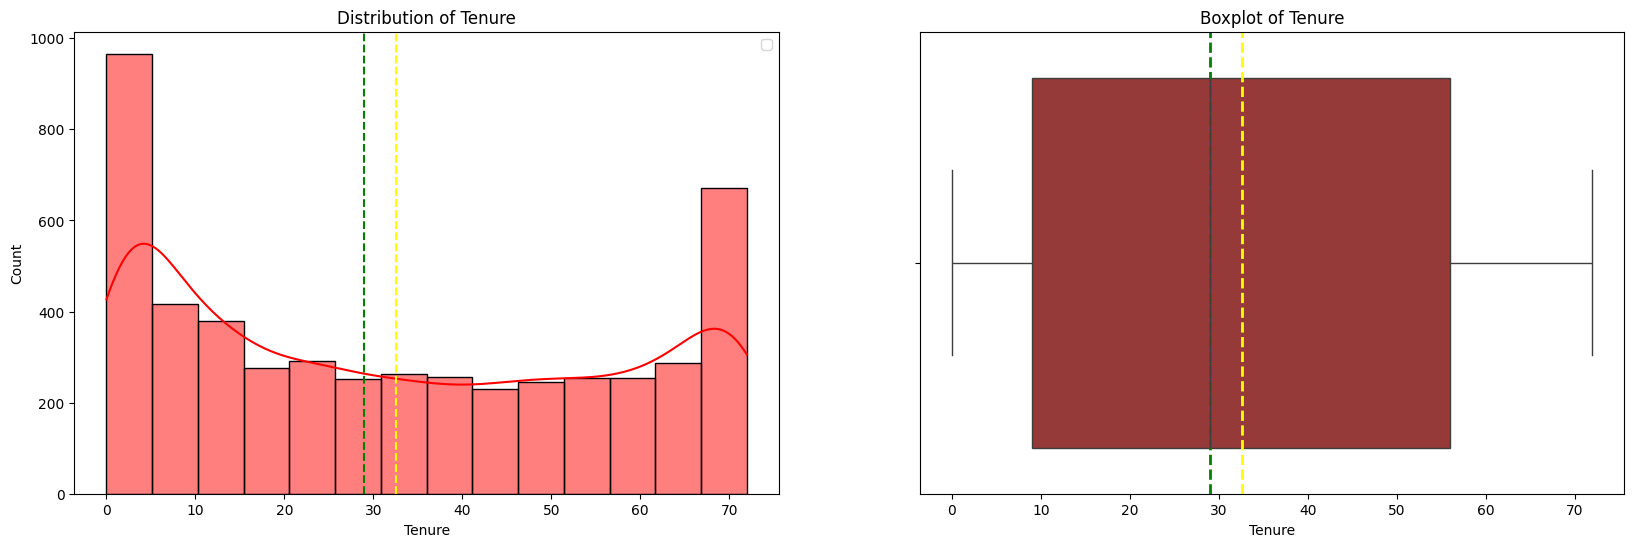

Column: MonthlyCharges
Skewness: -0.24
Kurtosis: -1.25
Mean: 65.09
Median: 70.55
------------------------------


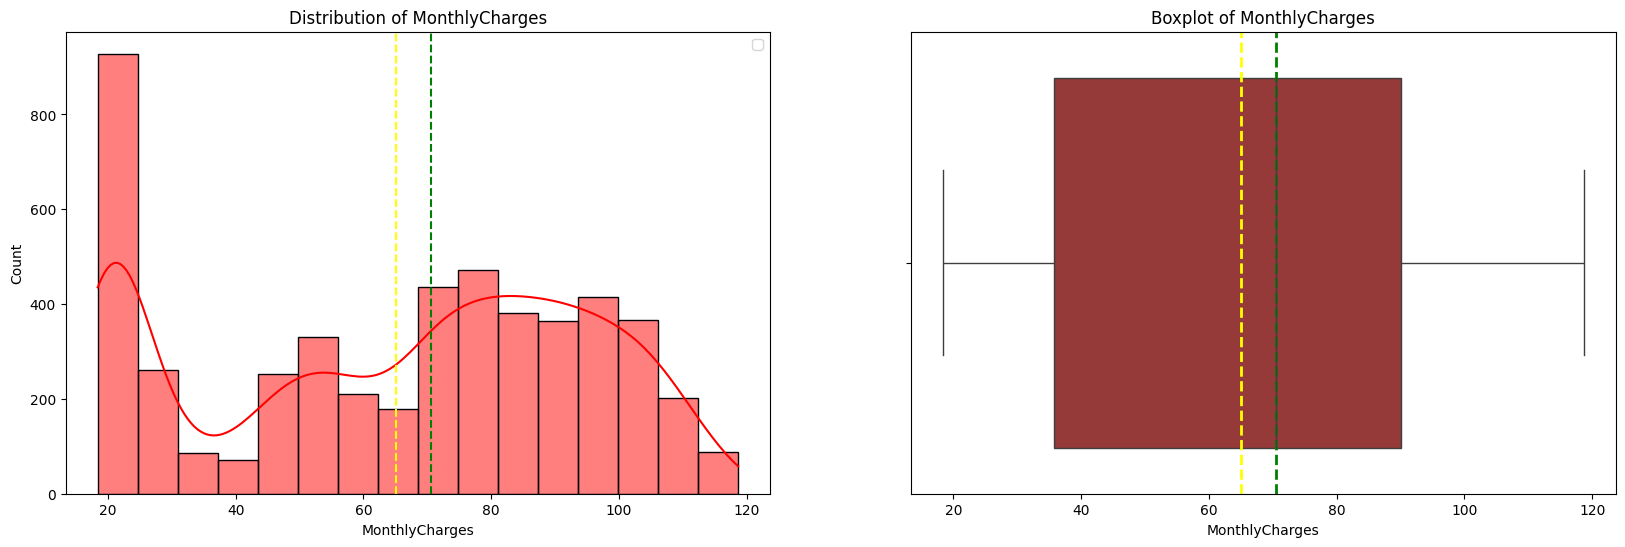

Column: TotalCharges
Skewness: 0.94
Kurtosis: -0.28
Mean: 2302.06
Median: 1401.15
------------------------------


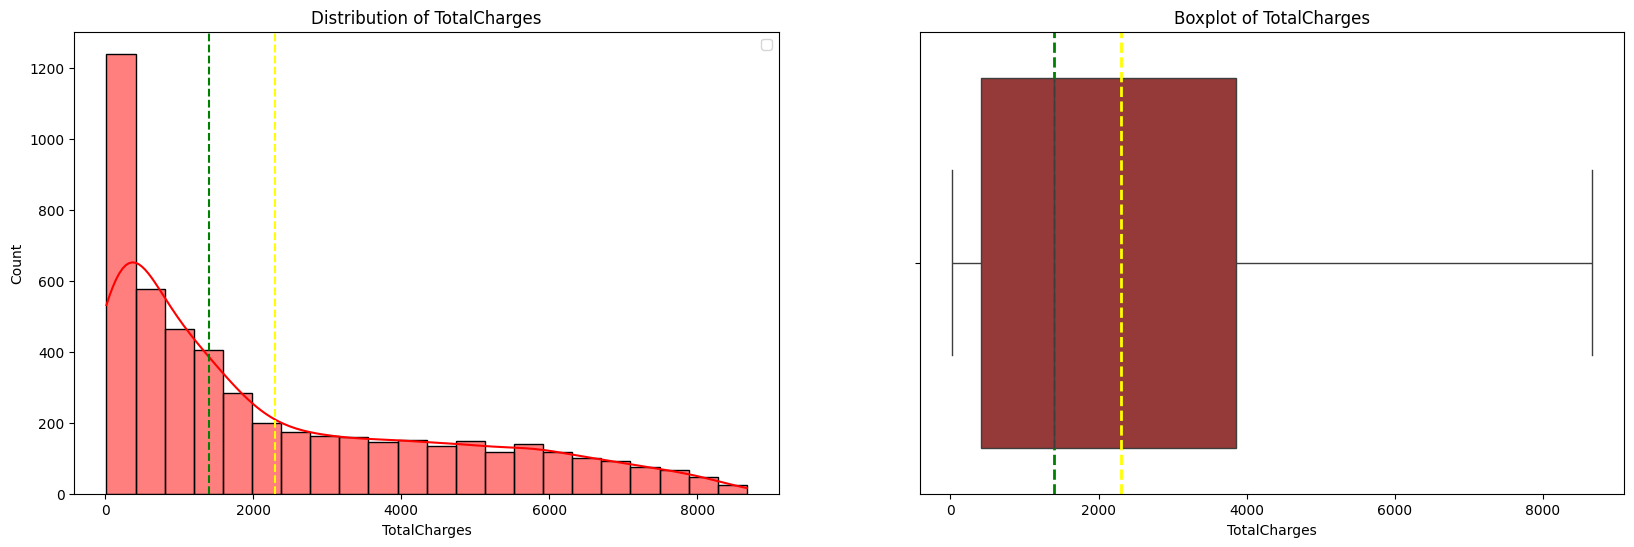

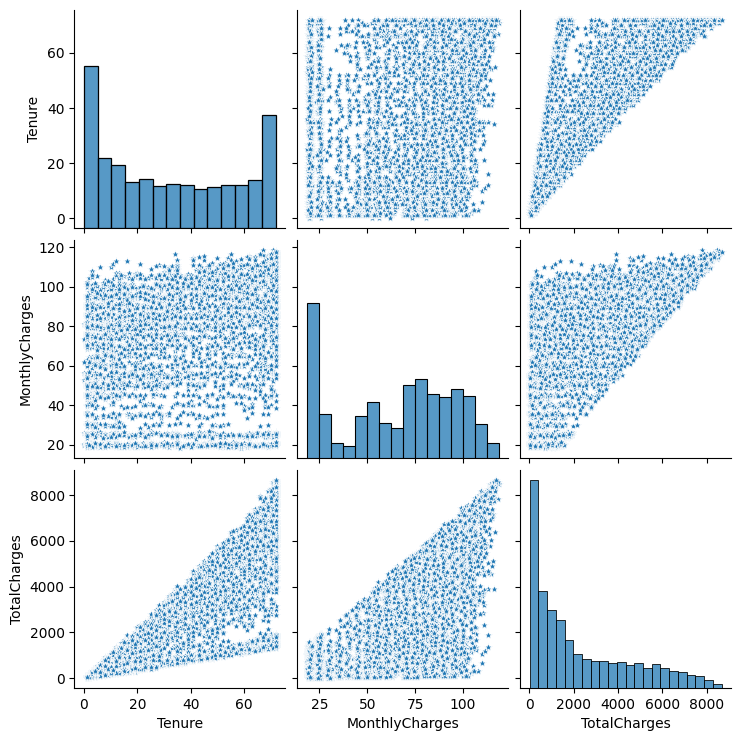

In [49]:
# ----------------------------------------------------------------------
# Iterate through numerical columns
# ----------------------------------------------------------------------
for col in numbers:

    # Calculating statistical measures
    skewness = round(numbers[col].skew(), 2)
    kurtosis = round(numbers[col].kurtosis(), 2)
    mean = round(numbers[col].mean(), 2)
    median = round(numbers[col].median(), 2)

    # Printing column statistics
    print(f"Column: {col}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print("-" * 30)

    # Setting plot size
    plt.figure(figsize=(20, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(numbers[col], kde=True, color="red", edgecolor="black")
    plt.axvline(mean, color="yellow", linestyle="dashed")
    plt.axvline(median, color="green", linestyle="dashed")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=numbers[col], color="brown")
    plt.axvline(mean, color="yellow", linestyle="dashed", linewidth=2)
    plt.axvline(median, color="green", linestyle="dashed", linewidth=2)
    plt.title(f"Boxplot of {col}")
    # plt.xlabel(col)
    # plt.ylabel("Count")
    # plt.legend()

    plt.show()
    
print()
# Pairplot
sns.pairplot(numbers, markers="*", palette="viridis")
plt.show()

#### Analysis for categorical features

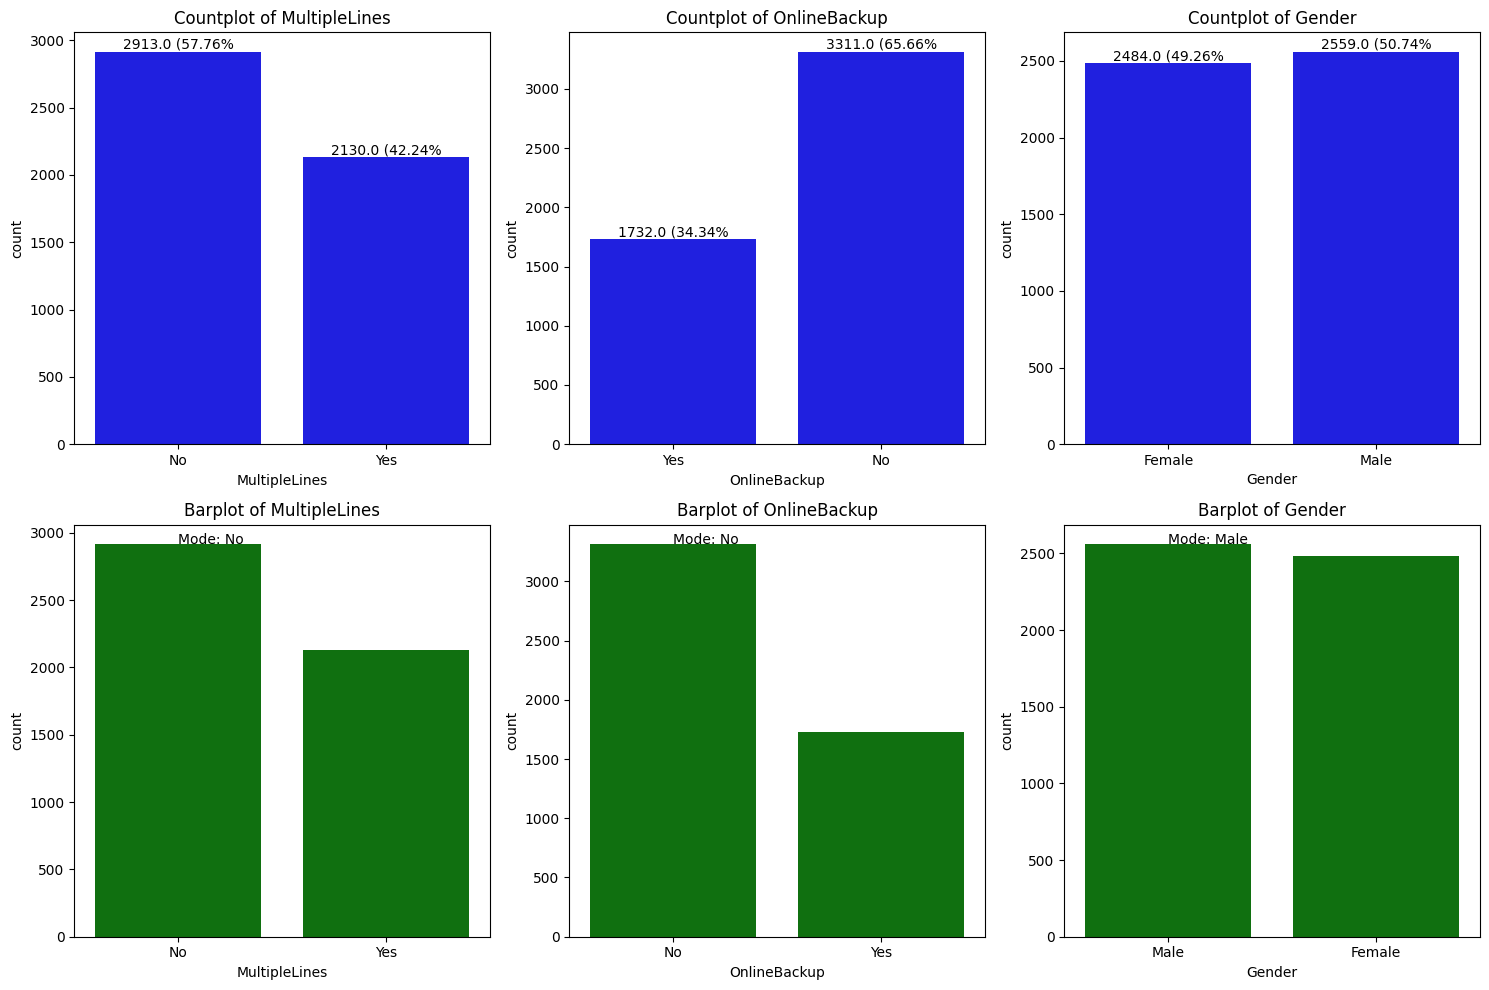

In [50]:

# --------------------------------------------------------
# Define function to visualize categorical columns
# --------------------------------------------------------
def visual_cat(train_data, columns):
    """
    Visualize categorical columns using countplots and barplots.

    Args:
    - train_data (pd.DataFrame): Input DataFrame.
    - columns (list): List of categorical column names.
    """
    fig, axes = plt.subplots(2, len(columns), figsize=(15, 10))

    for i, column in enumerate(columns):
        # Countplot
        sns.countplot(x=train_data[column], ax=axes[0, i], color="blue")
        axes[0, i].set_title(f"Countplot of {column}")

        # Adding labels
        total = len(train_data)
        for container in axes[0, i].containers:
            labels = [f"{h.get_height()} ({h.get_height()/total*100:.2f}%" if h.get_height() > 0 else "" for h in container]
            axes[0, i].bar_label(container, labels)

        # Barplot
        sns.barplot(x=train_data[column].value_counts().index, y=train_data[column].value_counts(), ax=axes[1, i], color="green")
        axes[1, i].set_title(f"Barplot of {column}")

        # Adding labels
        freq = train_data[column].mode().iloc[0]
        axes[1, i].annotate(f"Mode: {freq}", xy=(freq, train_data[column].value_counts().max()), color="black")

    plt.tight_layout()
    plt.show()


# Example usage
# --------------------------------------------------------
visual_cat(train_data, ["MultipleLines", "OnlineBackup", "Gender"])

### Bivariate Analysis

In [51]:
# --------------------------------------------------------
# Identify categorical columns
# --------------------------------------------------------
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_cols)

['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [52]:
# --------------------------------------------------------
# Assign variable to a list of all the categorical columns
# --------------------------------------------------------
all = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

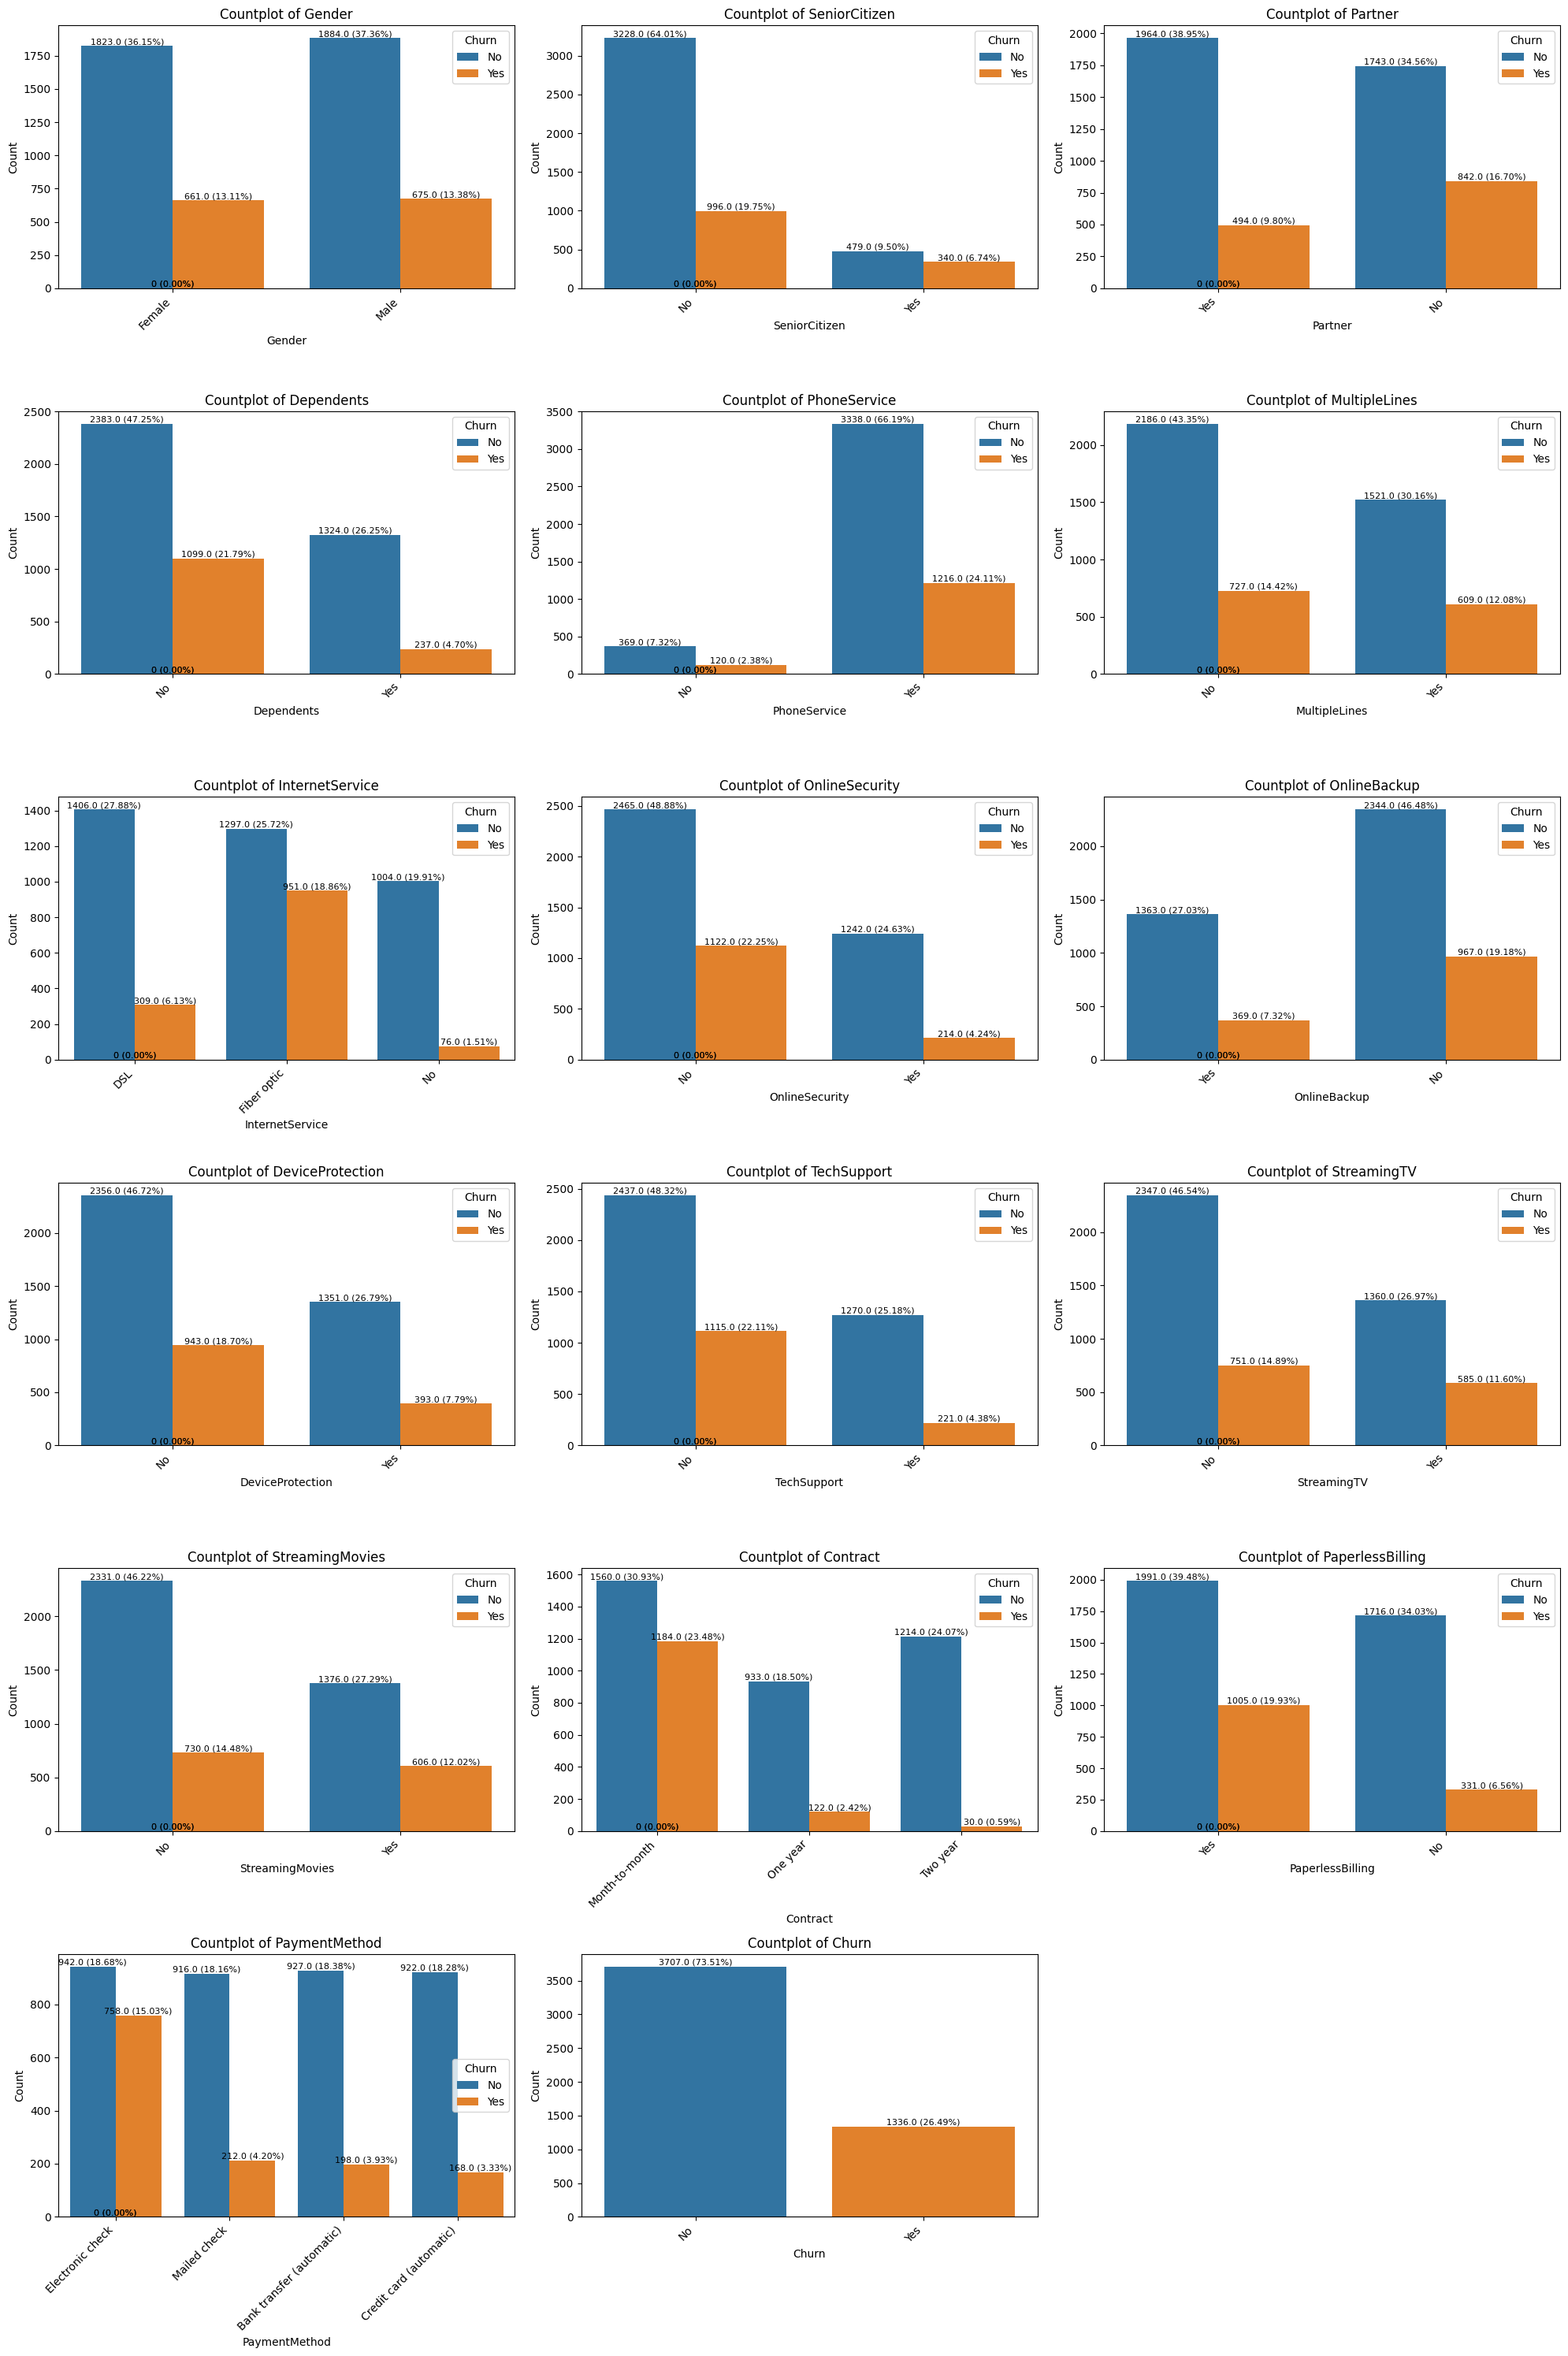

In [53]:
# --------------------------------------------------------
# Function to visualize categorical columns against target variable
# --------------------------------------------------------
def cat_vs_target(train_data, categorical_cols, target):
    # --------------------------------------------------------
    # Calculating rows dynamically
    # --------------------------------------------------------
    rows = (len(categorical_cols) + 2) // 3
    
    # --------------------------------------------------------
    # Create subplots
    # --------------------------------------------------------
    fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 5))

    for i, column in enumerate(categorical_cols):
        # --------------------------------------------------------
        # Select axis for current subplot
        # --------------------------------------------------------
        ax = axes[i // 3, i % 3] if rows > 1 else axes[i]
        
        # --------------------------------------------------------
        # Plot countplot with hue
        # --------------------------------------------------------
        sns.countplot(x=column, hue=target, data=train_data, ax=ax)

        # --------------------------------------------------------
        # Calculate total count for each subplot
        # --------------------------------------------------------
        total = train_data[column].count()

        # --------------------------------------------------------
        # Add count and percentage labels on bars
        # --------------------------------------------------------
        for patch in ax.patches:
            count = patch.get_height()
            percentage = (count / total) * 100
            label = f'{count} ({percentage:.2f}%)'
            ax.text(
                patch.get_x() + patch.get_width()/2,
                patch.get_height(),
                label,
                ha='center',
                va='bottom',
                size=8
            )
        # --------------------------------------------------------
        # Set plot title and labels
        # --------------------------------------------------------
        ax.set_title(f'Countplot of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')

        # --------------------------------------------------------
        # Rotate x-axis labels diagonally
        # --------------------------------------------------------
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # --------------------------------------------------------
    # Hide unused subplots
    # --------------------------------------------------------
    for i in range(len(categorical_cols), rows * 3):
        ax = axes[i // 3, i % 3] if rows > 1 else axes[i]
        ax.axis('off')

    # --------------------------------------------------------
    # Display plot
    # --------------------------------------------------------
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------
# Example usage
# --------------------------------------------------------
cat_vs_target(train_data, all, "Churn")

## KEY/ INSIGHTS / OBSERVATIONS from the visuals

### Multivariate Analysis

In [54]:
# --------------------------------------------------------
# Calculate correlation matrix
# --------------------------------------------------------
correlation = numbers.corr()
correlation

,Tenure,MonthlyCharges,TotalCharges
Tenure,1.000000,0.240645,0.826264
MonthlyCharges,0.240645,1.000000,0.647007
TotalCharges,0.826264,0.647007,1.000000


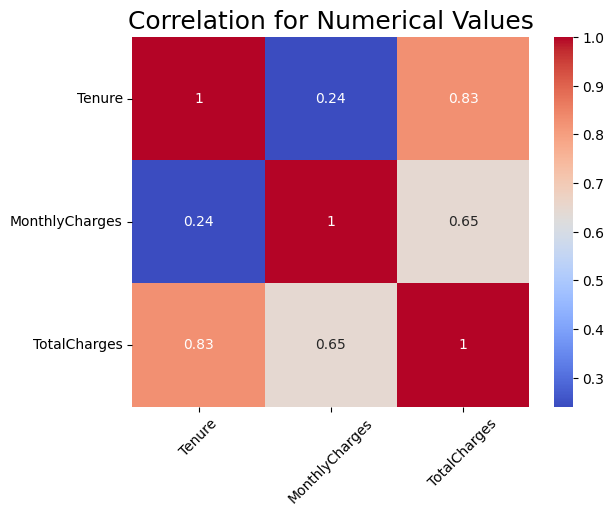

In [55]:
# --------------------------------------------------------
# Plot correlation heatmap
# --------------------------------------------------------
sns.heatmap(correlation, annot=True, cmap='coolwarm')

# --------------------------------------------------------
# Customize plot
# --------------------------------------------------------
plt.title('Correlation for Numerical Values', fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# --------------------------------------------------------
# Display plot
# --------------------------------------------------------
plt.show()

### Hypothesis 1

H0(Null Hypothesis): There is no significant difference in churn rates between customers with higher and lower monthly charge

H1(Alternative Hypothesis): There is significant difference in churn rates between customers with higher and lower monthly charge

In [56]:
# Grouping
# --------------------------------------------------------
# Create 'MC_Category' column
# --------------------------------------------------------
train_data['MC_Category'] = np.where(train_data['MonthlyCharges'] > train_data['MonthlyCharges'].mean(), 'high', 'low')

# --------------------------------------------------------
# Filter high monthly charges data
# --------------------------------------------------------
high_mc = train_data[train_data['MC_Category'] == 'high']

# --------------------------------------------------------
# Display high monthly charges data
# --------------------------------------------------------
high_mc

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MC_Category
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,high
5,Female,No,No,No,8.0,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes,high
6,Male,No,No,Yes,22.0,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No,high
8,Female,No,Yes,No,28.0,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes,high
12,Male,No,Yes,No,58.0,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,One year,No,Credit card (automatic),100.349998,5681.100098,No,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,Male,No,No,No,19.0,Yes,No,Fiber optic,No,No,...,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.700000,1495.100000,No,high
5038,Male,No,Yes,Yes,24.0,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No,high
5039,Female,No,Yes,Yes,72.0,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No,high
5041,Male,Yes,Yes,No,4.0,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes,high


In [57]:
# --------------------------------------------------------
# Filter low monthly charges data
# --------------------------------------------------------
low_mc = train_data[train_data['MC_Category'] == 'low']

# --------------------------------------------------------
# Display low monthly charges data
# --------------------------------------------------------
low_mc

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MC_Category
0,Female,No,Yes,No,1.0,No,No,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No,low
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No,low
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,low
3,Male,No,No,No,45.0,No,No,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No,low
7,Female,No,No,No,10.0,No,No,DSL,Yes,No,...,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,Female,No,No,No,2.0,Yes,No,No,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,20.050000,39.250000,No,low
5031,Male,Yes,Yes,No,55.0,Yes,Yes,DSL,Yes,Yes,...,No,No,No,One year,No,Credit card (automatic),60.000000,3316.100000,No,low
5036,Female,No,No,No,12.0,No,No,DSL,No,Yes,...,Yes,Yes,Yes,One year,No,Electronic check,60.650000,743.300000,No,low
5037,Female,No,No,No,72.0,Yes,No,No,No,No,...,No,No,No,Two year,Yes,Bank transfer (automatic),21.150000,1419.400000,No,low


In [58]:
## Method 1
# --------------------------------------------------------
# Using the chi square
# --------------------------------------------------------
# Create contingency table
# --------------------------------------------------------
contingency_table = pd.crosstab(train_data['Churn'], train_data['MC_Category'])

# --------------------------------------------------------
# Display contingency table
# --------------------------------------------------------
contingency_table 

MC_Category,high,low
Churn,,
No,1830,1877
Yes,981,355


In [59]:
# --------------------------------------------------------
# Performe the chi square
# --------------------------------------------------------
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"chi2:{chi2:.2f}, pi_value:{p_value}, degree_of_freedom: {dof}")

chi2:229.50, pi_value:7.648936379911372e-52, degree_of_freedom: 1


In [60]:
# --------------------------------------------------------
# Define significance level (alpha)
# --------------------------------------------------------
alpha = 0.05

# --------------------------------------------------------
# Hypothesis testing
# --------------------------------------------------------
if p_value < alpha:
    print("Null hypothesis rejected")
else:
    print("Null hypothesis not rejected")

Null hypothesis rejected


In [61]:
## Method 2
# --------------------------------------------------------
# Grouping data into *churned and *not churned
# --------------------------------------------------------
churned = train_data[train_data['Churn'] == 'Yes'] ['MonthlyCharges']
not_churned = train_data[train_data['Churn'] == 'No'] ['MonthlyCharges']

In [62]:
# --------------------------------------------------------
# Perform Mann-Whitney U test
# --------------------------------------------------------
u_stat, p_value = mannwhitneyu(churned, not_churned)

# --------------------------------------------------------
# Display results
# --------------------------------------------------------
print('U statistic:', u_stat)
print('p-value:', p_value)

U statistic: 3100791.0
p-value: 1.2019873209608733e-42


In [63]:
# --------------------------------------------------------
# Define significance level (alpha)
# --------------------------------------------------------
alpha = 0.05

# --------------------------------------------------------
# Hypothesis testing decision
# --------------------------------------------------------
if p_value < alpha:
    print("Null hypothesis rejected")
else:
    print("Null hypothesis not rejected")

Null hypothesis rejected


### Hypothesis 2

H0 (Null Hypothesis): Customer tenure has no significant effect on churn.

H1 (Alternative Hypothesis): Customer tenure has a significant effect on churn.

In [64]:
# --------------------------------------------------------
# Map Churn variable to numerical values
# --------------------------------------------------------
train_data['Churn'] = train_data['Churn'].map({'Yes': 1, 'No': 0})

Kaplan-Meier Survival Curve Interpretation:
-----------------------------------------------
Retained Customers Curve: Represents probability of remaining a customer over time.
Churned Customers Curve: Represents probability of churning over time.
Key Insights:
1. Higher curve indicates lower churn risk.
2. Steeper decline indicates faster churn rate.
3. Intersection points indicate equal churn risk.


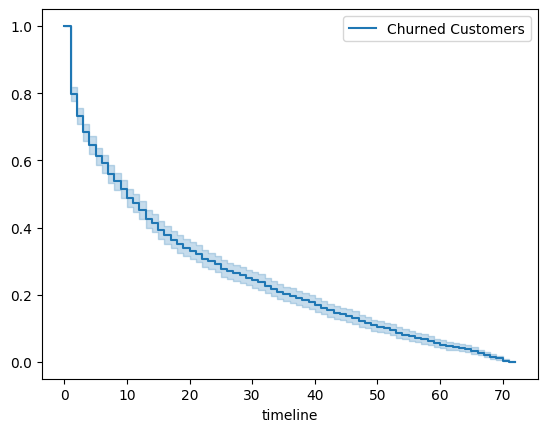

In [65]:
# Define tenure and churn variables
tenure = train_data['Tenure']
churn = train_data['Churn']

# Create Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit model
kmf.fit(tenure[churn==0], label='Retained Customers')
kmf.fit(tenure[churn==1], label='Churned Customers')

# Plot survival curves
kmf.plot()

# Interpretation
print("Kaplan-Meier Survival Curve Interpretation:")
print("-----------------------------------------------")
print("Retained Customers Curve: Represents probability of remaining a customer over time.")
print("Churned Customers Curve: Represents probability of churning over time.")
print("Key Insights:")
print("1. Higher curve indicates lower churn risk.")
print("2. Steeper decline indicates faster churn rate.")
print("3. Intersection points indicate equal churn risk.")

In [66]:
# Perform log-rank test
result = logrank_test(tenure[churn==0], tenure[churn==1])

# Extract test statistic and p-value
test_statistic = result.test_statistic
p_value = result.p_value

# Set significance level
alpha = 0.05  # Significance level

# Print test results
print("Log-Rank Statistic:", test_statistic)  # Log-Rank test statistic value
print("p-value:", p_value)  # Probability of observing test statistic under H0

# Interpret test results
if p_value < alpha:  # Check if p-value is below significance level
    print("Reject H0: Customer tenure has no significant effect on churn.")  # Reject null hypothesis
else:
    print("Fail to reject H0: Customer tenure has a significant effect on churn.")  # Fail to reject null hypothesis

# Additional insights
# TODO: Analyze survival curves for intuitive insights.
# TODO: Consider additional predictors (e.g., usage patterns, demographic data).
# TODO: Develop targeted retention strategies based on test results.

Log-Rank Statistic: 789.2728987278504
p-value: 1.1596999416300337e-173
Reject H0: Customer tenure has no significant effect on churn.


In [67]:
if p_value < alpha:
    print("Log-Rank Test Result: Rejects the Null Hypothesis (H0)")
    print(f"Customer tenure has a significant effect on churn. (p-value={p_value:.2e})")
else:
    print("Log-Rank Test Result: Fails to Reject the Null Hypothesis (H0)")
    print(f"Customer tenure has a significant effect on churn. (p-value={p_value:.2e})")

Log-Rank Test Result: Rejects the Null Hypothesis (H0)
Customer tenure has a significant effect on churn. (p-value=1.16e-173)


### Hypothesis 3

H0 (Null Hypothesis): The average monthly charge for churned customers is equal to the average monthly charge for non-churned customers.

H1 (Alternative Hypothesis): The average monthly charge for churned customers is not equal to the average monthly charge for non-churned customers.

In [68]:
# Using Ordinary Least Squares (OLS) Regression

# Define predictor and response variables
X = train_data['Churn']
y = train_data['MonthlyCharges']

# Add constant (intercept) to predictor
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Null Hypothesis (H0): Coefficient of Churn is 0 (no effect)
# Alternative Hypothesis (H1): Coefficient of Churn is not 0 (significant effect)

# Extract p-value for Churn coefficient
p_value = model.pvalues['Churn']

# Set significance level
alpha = 0.05

# Print regression summary
print(model.summary())

# Hypothesis testing
if p_value < alpha:
    print("Reject H0: Churn has a significant effect on Monthly Charges.")
else:
    print("Fail to reject H0: Churn has no significant effect on Monthly Charges.")

                            OLS Regression Results                            
Dep. Variable:         MonthlyCharges   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     214.6
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.26e-47
Time:                        13:33:53   Log-Likelihood:                -24214.
No. Observations:                5043   AIC:                         4.843e+04
Df Residuals:                    5041   BIC:                         4.844e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.4427      0.484    127.024      0.0

## Business Questions

1. What is the average tenure of customers who churned compared to those who stayed?
2. Do customers with partners or dependants have a lower churn rate?
3. What is the distribution of customer tenure among churned and non-churned customers?
4. Is there a significant difference in churn rates between customers with different payment methods?
5. Which demographic factors (age, gender, senior citizen, partner, dependents) are most associated with customer churn?
6. What is the average monthly charge for customers who churned within the first year?
7. How does internet service usage impact customer churn?

In [69]:
# --------------------------------------------------------
# Display the first few rows of the training data
# --------------------------------------------------------
train_data.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MC_Category
0,Female,No,Yes,No,1.0,No,No,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0,low
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0,low
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,low
3,Male,No,No,No,45.0,No,No,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,0,low
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,1,high


##### 1. What is the average tenure of customers who churned compared to those who stayed?

In [70]:
# --------------------------------------------------------
# Segment customers by churn status
# --------------------------------------------------------
criteria = train_data["Churn"] == 1  # Updated criteria to match mapped values
left_customer = train_data[criteria]
stayed_customer = train_data[~criteria]

# --------------------------------------------------------
# Calculate average tenure for churned and stayed customers
# --------------------------------------------------------
avg_tenure_churned = left_customer["Tenure"].mean()
avg_tenure_not_churned = stayed_customer["Tenure"].mean()

# --------------------------------------------------------
# Print results
# --------------------------------------------------------
print(f"Average tenure of churned customers: {avg_tenure_churned:.0f} months")
print(f"Average tenure of stayed customers: {avg_tenure_not_churned:.0f} months")

Average tenure of churned customers: 18 months
Average tenure of stayed customers: 38 months


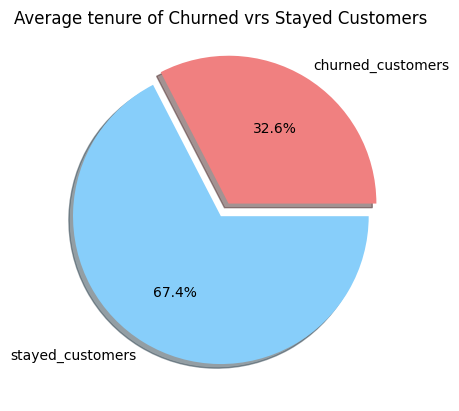

In [71]:
# --------------------------------------------------------
# Plotting
# --------------------------------------------------------

label = ["churned_customers", "stayed_customers"]
sizes = [avg_tenure_churned, avg_tenure_not_churned]
colors = ["lightcoral", "lightskyblue"]
explode = (0.1, 0)

plt.pie(sizes, explode = explode, labels = label, colors = colors, autopct = "%1.1f%%", shadow = True)
plt.title("Average tenure of Churned vrs Stayed Customers")
plt.show()

In [72]:
# ----------------------------------------------------------------------
# Filling for numerical - TotalCharges
# ----------------------------------------------------------------------

# train_data["TotalCharges"].fillna(train_data["TotalCharges"].median(), inplace = True)

# ----------------------------------------------------------------------
# Selecting the categorical columns with the mising values
# ----------------------------------------------------------------------

# cat_cols = train_data[["MultipleLines","OnlineSecurity","OnlineBackup",
                       #"DeviceProtection", "TechSupport", "StreamingTV","StreamingMovies", "Churn"]]
#for col in cat_cols:
    #train_data[col].replace("",np.nan,inplace = True) # Replacing empty strings with NaN
    #train_data[col].replace("NaN",np.nan,inplace = True) # Replacing string NaN with NaN
    #train_data[col].replace("nan",np.nan,inplace = True)  # Replacing string nan with NaN
    # train_data[col].fillna(train_data[col].mode()[0],inplace = True) # Fill all other nan with mode

#### 2. Do customers with partners or dependants have a lower churn rate?

In [73]:
# Map 'Churn' column to numeric values
#train_data['Churn'] = train_data['Churn'].map({'Yes': 1, 'No': 0})

# Group data by Partner and Dependents, calculating Churn rate
partner_dependents_churn = train_data.groupby(['Partner', 'Dependents'])['Churn'].mean().reset_index()

# Rename Churn column to Churn Rate
partner_dependents_churn = partner_dependents_churn.rename(columns={'Churn': 'Churn Rate'})

# Print results
print(partner_dependents_churn)

  Partner Dependents  Churn Rate
0      No         No    0.339078
1      No        Yes    0.208333
2     Yes         No    0.268734
3     Yes        Yes    0.140324


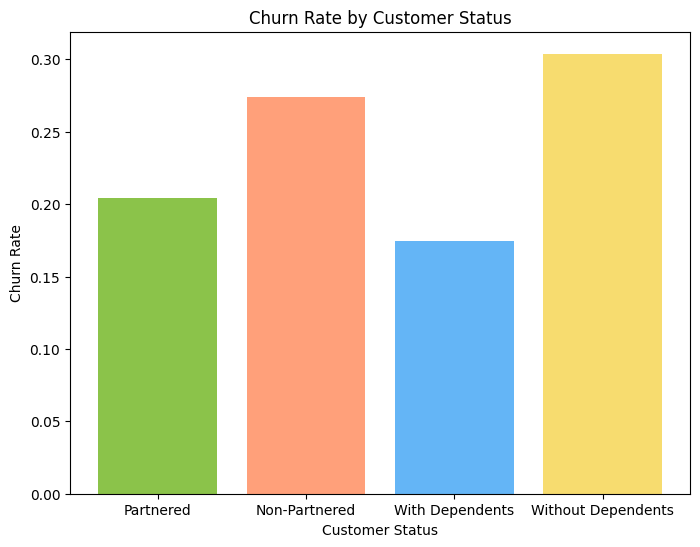

In [74]:
# --------------------------------------------------------
# Calculating overall churn rates
# --------------------------------------------------------
partnered_churn = partner_dependents_churn[partner_dependents_churn['Partner'] == 'Yes']['Churn Rate'].mean()
non_partnered_churn = partner_dependents_churn[partner_dependents_churn['Partner'] == 'No']['Churn Rate'].mean()
with_dependents_churn = partner_dependents_churn[partner_dependents_churn['Dependents'] == 'Yes']['Churn Rate'].mean()
without_dependents_churn = partner_dependents_churn[partner_dependents_churn['Dependents'] == 'No']['Churn Rate'].mean()

# --------------------------------------------------------
# Creating bar plot
# --------------------------------------------------------
plt.figure(figsize=(8, 6))
labels = ['Partnered', 'Non-Partnered', 'With Dependents', 'Without Dependents']
churn_rates = [partnered_churn, non_partnered_churn, with_dependents_churn, without_dependents_churn]
colors = ['#8BC34A', '#FFA07A', '#64B5F6', '#F7DC6F']
plt.bar(labels, churn_rates, color=colors)
plt.xlabel('Customer Status')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Customer Status')
plt.show()

#### 3. What is the distribution of customer tenure among churned and non-churned customers?

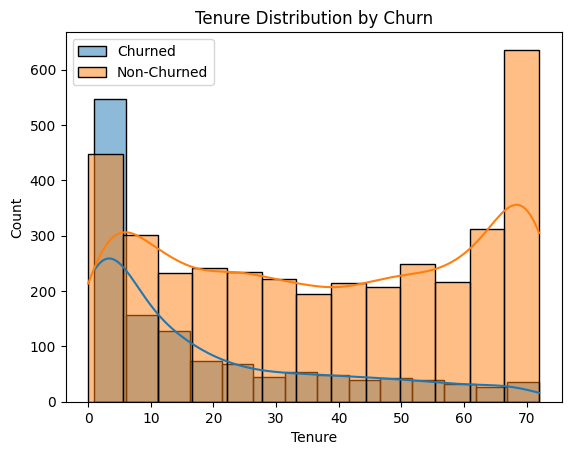

In [75]:
# --------------------------------------------------------
# Plot tenure distribution for churned and non-churned customers
# --------------------------------------------------------
sns.histplot(train_data[train_data['Churn'] == 1]['Tenure'], kde=True, label='Churned')
sns.histplot(train_data[train_data['Churn'] == 0]['Tenure'], kde=True, label='Non-Churned')
plt.title('Tenure Distribution by Churn')
plt.legend()
plt.show()

#### 4. Is there a significant difference in churn rates between customers with different payment methods?

chi2 statistic: 434.57845299430187, p-value: 7.15250271664344e-94
Significant difference in churn rates by payment method


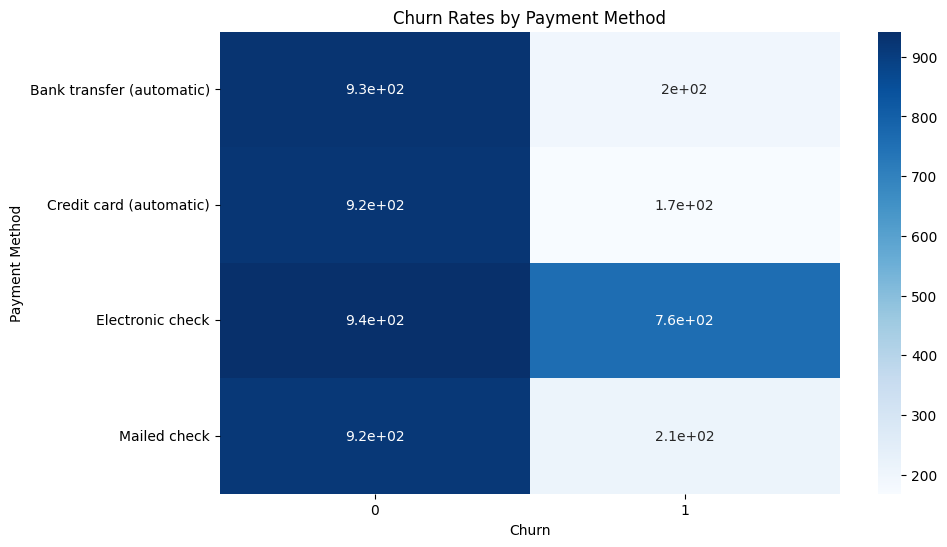

<Figure size 1000x600 with 0 Axes>

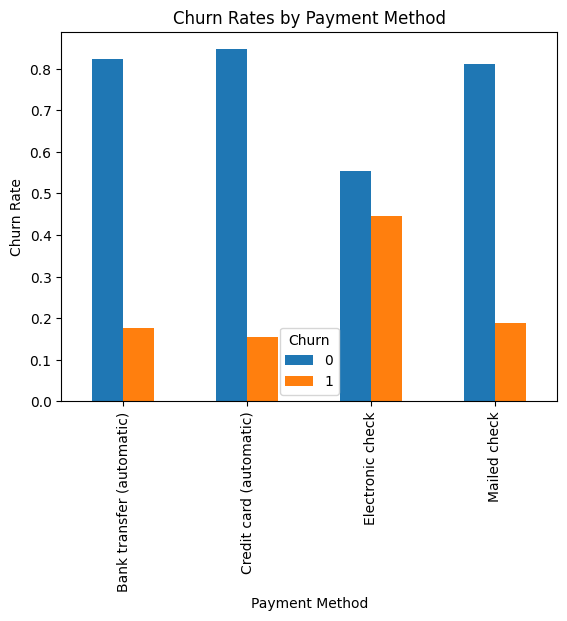

In [76]:
# --------------------------------------------------------
# Create contingency table
# --------------------------------------------------------
contingency_table = pd.crosstab(train_data['PaymentMethod'], train_data['Churn'])

# --------------------------------------------------------
# Perform chi-squared test
# --------------------------------------------------------
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# --------------------------------------------------------
# Print test results
# --------------------------------------------------------
print(f"chi2 statistic: {chi2_stat}, p-value: {p_value}")

# Interpret test results
if p_value < 0.05:
    print("Significant difference in churn rates by payment method")
else:
    print("No significant difference")

# --------------------------------------------------------
# Visualize contingency table
# --------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="Blues")
plt.title("Churn Rates by Payment Method")
plt.xlabel("Churn")
plt.ylabel("Payment Method")
plt.show()

# --------------------------------------------------------
# Additional visualization: Bar plot
# --------------------------------------------------------
churn_rates = contingency_table.div(contingency_table.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
churn_rates.plot(kind="bar")
plt.title("Churn Rates by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Churn Rate")
plt.show()

#### 5. Which demographic factors (age, gender, senior citizen, partner, dependents) are most associated with customer churn?

Gender: chi2 statistic = 0.024146708104267937, p-value = 0.8765122032778316
Gender is not associated with customer churn
SeniorCitizen: chi2 statistic = 112.38513864964213, p-value = 2.9422590466795336e-26
SeniorCitizen is associated with customer churn
Partner: chi2 statistic = 100.04803310210906, p-value = 1.4874557160211958e-23
Partner is associated with customer churn
Dependents: chi2 statistic = 147.65303980235052, p-value = 5.64905170330451e-34
Dependents is associated with customer churn


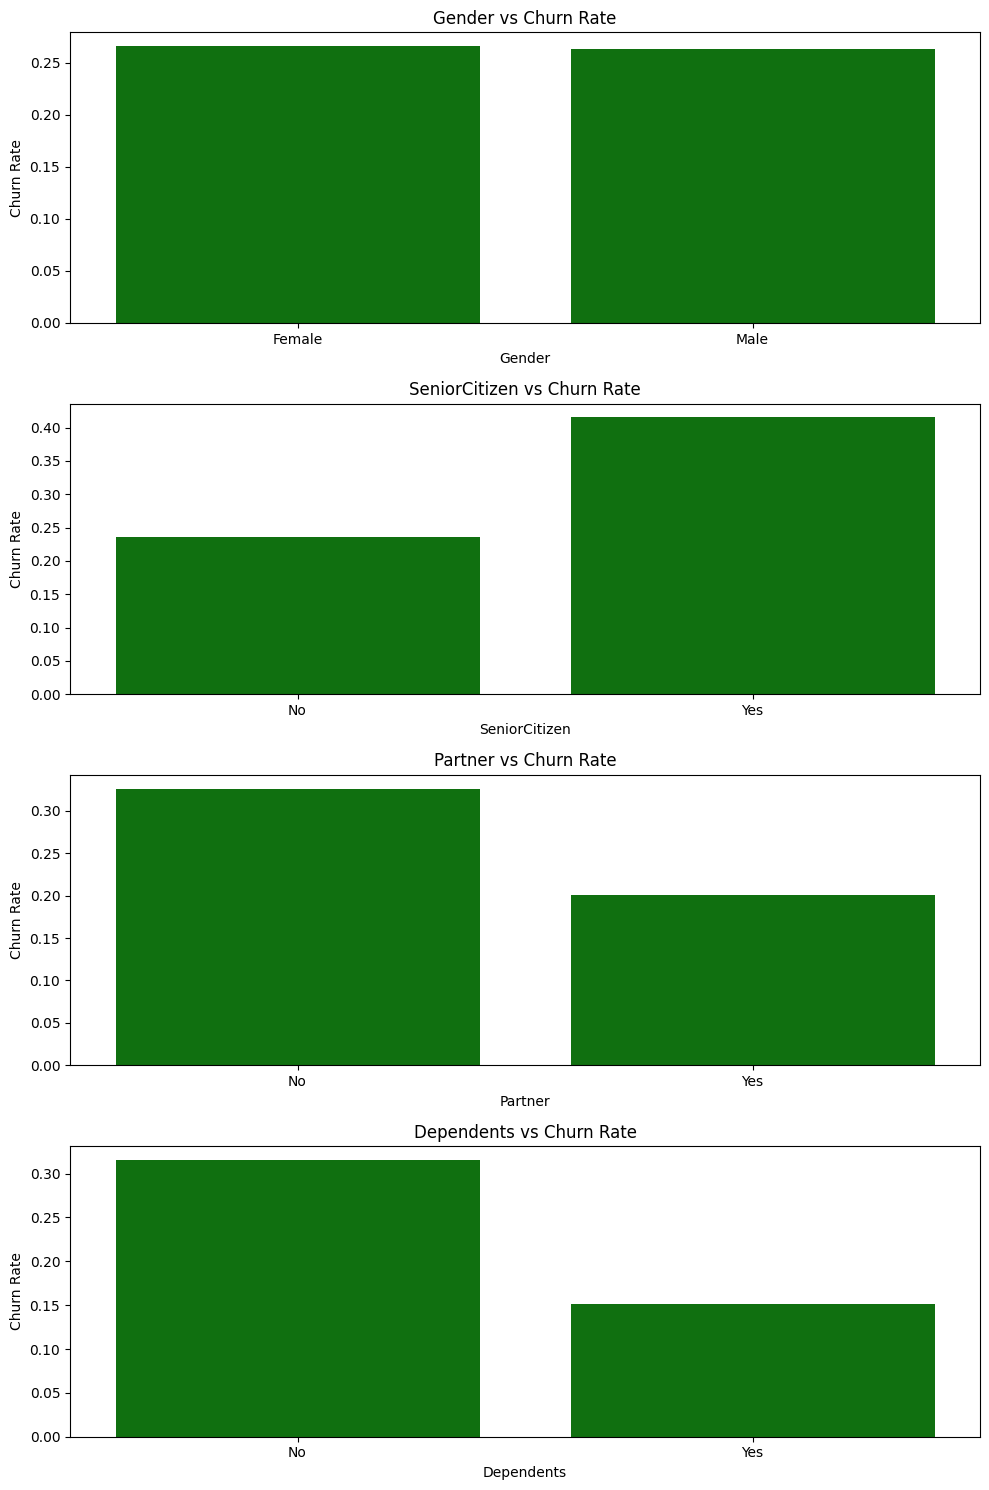

In [77]:
# --------------------------------------------------------
# Define demographic columns
# --------------------------------------------------------
demographic_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']

# --------------------------------------------------------
# Create figure with subplots
# --------------------------------------------------------
fig, axes = plt.subplots(nrows=len(demographic_cols), figsize=(10, 15))

# --------------------------------------------------------
# Perform chi-squared test and visualize results
# --------------------------------------------------------
for i, col in enumerate(demographic_cols):
    contingency_table = pd.crosstab(train_data[col], train_data['Churn'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"{col}: chi2 statistic = {chi2_stat}, p-value = {p_value}")

    if p_value < 0.05:
        print(f"{col} is associated with customer churn")
    else:
        print(f"{col} is not associated with customer churn")

# --------------------------------------------------------
    # Bar plot for each demographic factor
# --------------------------------------------------------
    sns.barplot(ax=axes[i], x=contingency_table.index, y=contingency_table[1] / contingency_table.sum(axis=1), color = 'green')
    axes[i].set_title(f"{col} vs Churn Rate")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Churn Rate")

plt.tight_layout()
plt.show()

#### 6. What is the average monthly charge for customers who churned within the first year?

Average monthly charge for early churners: 67.21152796465573


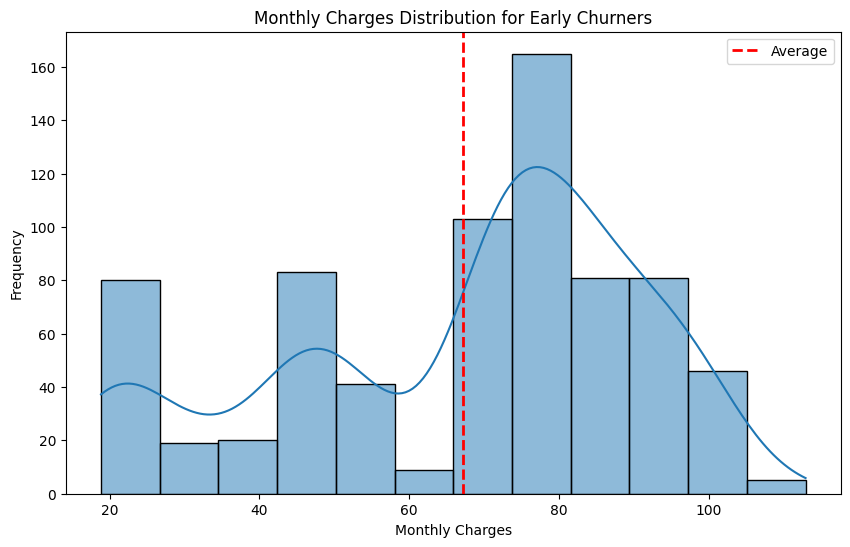

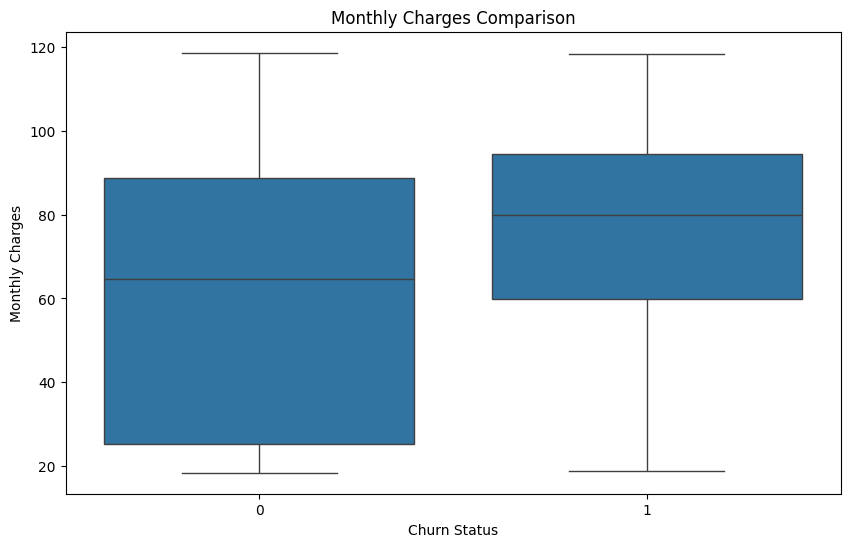

In [78]:
# --------------------------------------------------------
# Calculate average monthly charge for customers who churned within first year
# --------------------------------------------------------
early_churners = train_data[(train_data['Churn'] == 1) & (train_data['Tenure'] <= 12)]
avg_monthly_charge = early_churners['MonthlyCharges'].mean()

print(f"Average monthly charge for early churners: {avg_monthly_charge}")

# --------------------------------------------------------
# Histogram of monthly charges for early churners
# --------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(early_churners['MonthlyCharges'], kde=True)
plt.axvline(avg_monthly_charge, color='red', linestyle='dashed', linewidth=2, label='Average')
plt.title("Monthly Charges Distribution for Early Churners")
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --------------------------------------------------------
# Boxplot comparing monthly charges for early churners and non-churners
# --------------------------------------------------------
non_early_churners = train_data[(train_data['Churn'] == 0) | (train_data['Tenure'] > 12)]
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=train_data)
plt.title("Monthly Charges Comparison")
plt.xlabel("Churn Status")
plt.ylabel("Monthly Charges")
plt.show()

#### 7. How does internet service usage impact customer churn?

Internet service usage: chi2 statistic = 561.7822685229834, p-value = 1.0245434346853363e-122
Internet service usage is associated with customer churn


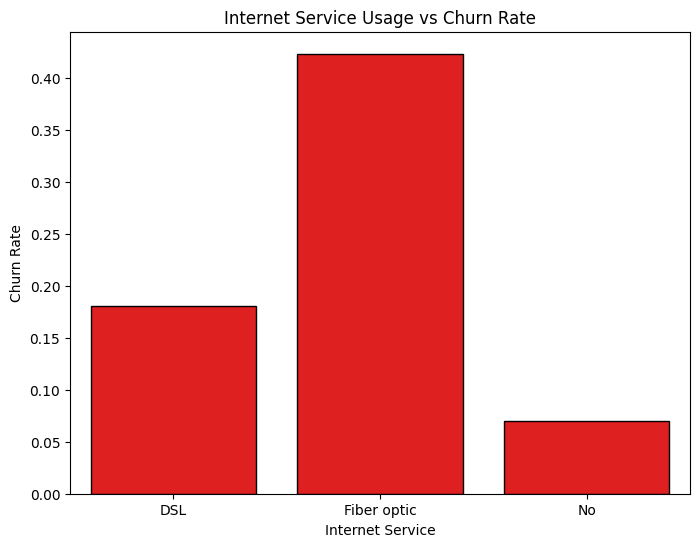

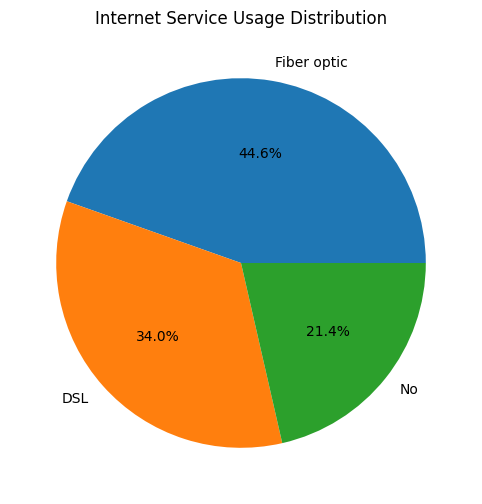

In [79]:
# --------------------------------------------------------
# Perform chi-squared test
# --------------------------------------------------------
contingency_table = pd.crosstab(train_data['InternetService'], train_data['Churn'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Internet service usage: chi2 statistic = {chi2_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("Internet service usage is associated with customer churn")
else:
    print("Internet service usage is not associated with customer churn")
    
# --------------------------------------------------------
# Bar plot for internet service usage vs churn rate
# --------------------------------------------------------
churn_rates = contingency_table.div(contingency_table.sum(axis=1), axis=0)[1]
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values, color = 'red', edgecolor = 'black')
plt.title("Internet Service Usage vs Churn Rate")
plt.xlabel("Internet Service")
plt.ylabel("Churn Rate")
plt.show()

print()
# --------------------------------------------------------
# Pie chart for internet service usage distribution
# --------------------------------------------------------
internet_service_counts = train_data['InternetService'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(internet_service_counts, labels=internet_service_counts.index, autopct='%1.1f%%')
plt.title("Internet Service Usage Distribution")
plt.show()

## DATA PREPARATION

In [80]:
# --------------------------------------------------------
# Display the first 3 rows of the training data
# --------------------------------------------------------
train_data.head(3)

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MC_Category
0,Female,No,Yes,No,1.0,No,No,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0,low
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0,low
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,low


In [81]:
# --------------------------------------------------------
# Map 'Churn' column to categorical values
# --------------------------------------------------------
train_data['Churn'] = train_data['Churn'].map({1: 'Yes', 0: 'No'})

In [82]:
# --------------------------------------------------------
# Drop 'MC_Category' column
# --------------------------------------------------------
train_data.drop(columns=["MC_Category"], inplace=True)

In [83]:
# Verify

train_data.head(3)

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1.0,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes


In [84]:
# --------------------------------------------------------
# Creat a copy of the data
# --------------------------------------------------------
train_mod = train_data.copy()

In [85]:
# ---------------------------------------- 
# Print Churn value counts
# ---------------------------------------- 
print(train_mod['Churn'].value_counts())  # Display count of each Churn category

Churn
No     3707
Yes    1336
Name: count, dtype: int64


In [86]:
# ---------------------------------------- 
# Print unique Churn values
# ----------------------------------------
print(train_mod['Churn'].unique())  # Display unique categories in Churn column

['No' 'Yes']


In [87]:
# --------------------------------------------------------
# Check for data imbalance
# --------------------------------------------------------
train_mod["Churn"].value_counts()

Churn
No     3707
Yes    1336
Name: count, dtype: int64

In [88]:
# ---------------------------------------- 
# Resampling execution
# ---------------------------------------- 

# resample
# smote

In [89]:
## Methos 1
# --------------------------------------------------------
# Split data into majority and minority classes
# --------------------------------------------------------
churn_major = train_mod[train_mod["Churn"] == "No"]
churn_minor = train_mod[train_mod["Churn"] == "Yes"]

# --------------------------------------------------------
# Resample minority class to match majority class size
# --------------------------------------------------------
minor_resampled = resample(churn_minor, 
                           replace=True, 
                           n_samples=len(churn_major), 
                           random_state=42)

# --------------------------------------------------------
# Combine resampled minority and majority classes
# --------------------------------------------------------
train_model = pd.concat([churn_major, minor_resampled])

# --------------------------------------------------------
# Verify class balance
# --------------------------------------------------------
print(train_model["Churn"].value_counts())

Churn
No     3707
Yes    3707
Name: count, dtype: int64


In [90]:
# ---------------------------------------- 
# Split data
# ---------------------------------------- 

# With train_model as the new Dataframe
# ---------------------------------------- 
X = train_model.drop('Churn', axis=1)  # Features
y = train_model['Churn'].apply (lambda x:1 if x == 'Yes' else 0)  # Target variable
# ---------------------------------------- 

# Split data into training and testing sets
# ---------------------------------------- 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [91]:
# ---------------------------------------- 
# Printing training and testing data shapes
# ---------------------------------------- 

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((5931, 19), (5931,)), ((1483, 19), (1483,)))

In [92]:
# ---------------------------------------- 
# Separating into categorical and numerical columns
# ---------------------------------------- 

num_cols = X.select_dtypes(include=['int64', 'float64']).columns

cat_cols = X.select_dtypes(include=['object']).columns

In [93]:
# ----------------------------------------
# Define Numerical Pipeline
# ----------------------------------------
num_pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),  # Scale numerical values
    ('qt', QuantileTransformer(output_distribution='normal'))  # Transform to normal distribution
])

# ---------------------------------------- 
# Define Categorical Pipeline
# ---------------------------------------- 
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(  # One-hot encode categorical values
handle_unknown='ignore',  # Ignore unknown categories
sparse_output=False  # Dense output
))
])

# ---------------------------------------- 
# Define Preprocessor
# ---------------------------------------- 
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipe, num_cols),  # Apply num_pipe to numerical columns
    ('categorical', cat_pipe, cat_cols)  # Apply cat_pipe to categorical columns
])


# ---------------------------------------- 
# Print 
# ---------------------------------------- 
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('qt',
                                                  QuantileTransformer(output_distribution='normal'))]),
                                 Index(['Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])

## MODELING & EVALUATION

In [94]:
# %pip install catboost

In [95]:
# %pip install lightgbm

In [96]:
# %pip install xgboost

In [97]:
# %pip install imbalanced-learn

In [98]:
# ---------------------------------------- 
# Define Machine Learning Models
# ---------------------------------------- 

models = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42, solver = 'liblinear')),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVC', SVC(C=1.0, kernel='rbf', random_state=42)),
    ('GB', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('XB', XGBClassifier(random_state=42, learning_rate=0.1))
]

In [99]:
# ---------------------------------------- 
# Define oversampling technique
# ---------------------------------------- 
sampler = SMOTE(random_state = 42)

In [100]:
# Define Pipelines ----------------------------------------
pipelines = []
# ---------------------------------------- 

# Iterate through Models ----------------------------------------
for model, classifier in models:
# ---------------------------------------- 
    
# Create Pipeline ----------------------------------------
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocess data
        ('smote_sampler', SMOTE()),  # Handle class imbalance with SMOTE
        ('classifier', classifier)  # Classify using selected model
])
# ---------------------------------------- 

# Append Model and Pipeline ----------------------------------------
    pipelines.append((model, pipeline))

In [101]:
# Evaluate Models # ----------------------------------------
eval_result = {}

for model, classifier in models:
    pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote_sampler', SMOTE()),
    ('model', classifier)
])

    pipeline.fit(X_train, y_train)

    X_val_processed = pipeline.named_steps['preprocessor'].transform(X_val)
    y_pred = pipeline.named_steps['model'].predict(X_val_processed)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)

    eval_result[model] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'confusion_matrix': conf_matrix
}

# Create Scores DataFrame # ----------------------------------------
scores_df = pd.DataFrame(eval_result).transpose()

# Sort Scores by F1 Score # ----------------------------------------
scores_dff = scores_df.sort_values(by='f1_score', ascending=False)

# Print Models Scores # ----------------------------------------
print('Models Scores:')
scores_dff

Models Scores:


,accuracy,f1_score,precision,recall,predictions,confusion_matrix
RF,0.902225,0.907937,0.857314,0.964912,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[623, 119], [26, 715]]"
XB,0.828726,0.839037,0.79092,0.893387,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[567, 175], [79, 662]]"
GB,0.784895,0.796166,0.756068,0.840756,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[541, 201], [118, 623]]"
KNN,0.774107,0.793592,0.730159,0.869096,"[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[504, 238], [97, 644]]"
SVC,0.777478,0.790076,0.747292,0.838057,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[[532, 210], [120, 621]]"
LR,0.770735,0.782051,0.744811,0.823212,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...","[[533, 209], [131, 610]]"


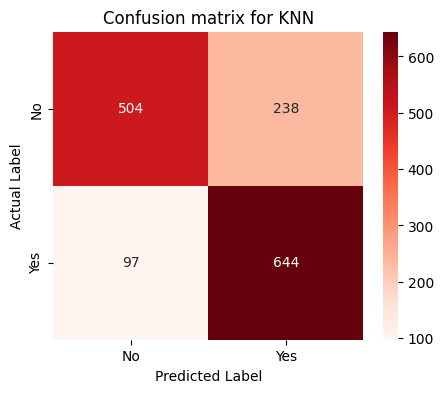

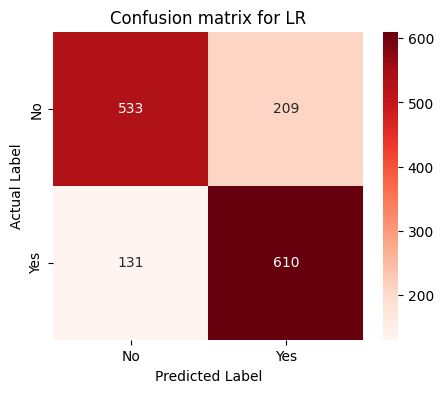

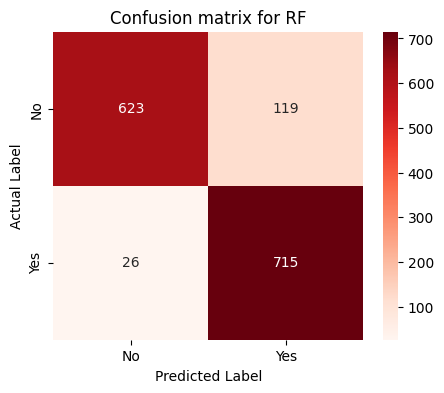

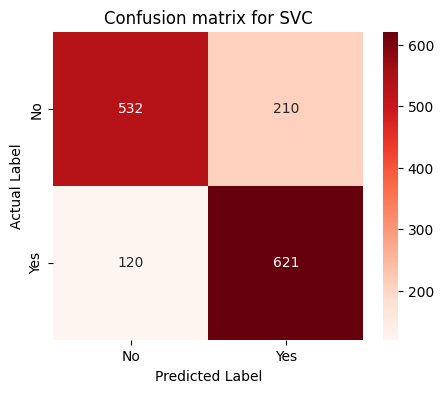

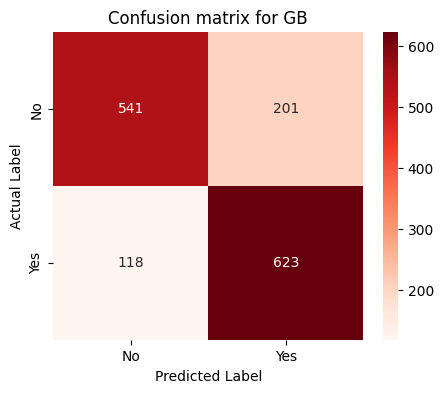

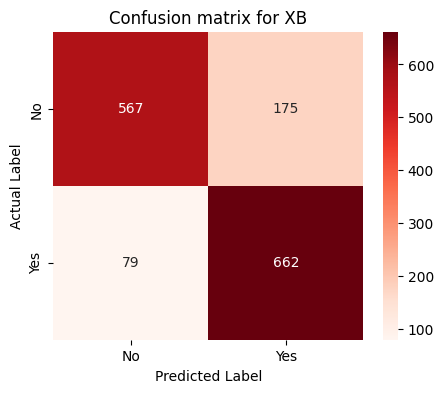

In [102]:
def plot_conf_matrix(conf_matrix, model):
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt ='d', cmap='Reds', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion matrix for {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

# Plot Confusion Matrices for All Models # ----------------------------------------
for model in eval_result.keys():
    conf_matrix = eval_result[model]['confusion_matrix']
    plot_conf_matrix(conf_matrix, model)

In [103]:
# ----------------------------------------
# Classification Reports for All Models 
# ----------------------------------------

for model, classifier in models:

    print(f'Classification report for {model}:')
    print(classification_report(y_val,y_pred, target_names = ['No', 'Yes']))
    print("="*30 + "\n")

Classification report for KNN:
              precision    recall  f1-score   support

          No       0.88      0.76      0.82       742
         Yes       0.79      0.89      0.84       741

    accuracy                           0.83      1483
   macro avg       0.83      0.83      0.83      1483
weighted avg       0.83      0.83      0.83      1483


Classification report for LR:
              precision    recall  f1-score   support

          No       0.88      0.76      0.82       742
         Yes       0.79      0.89      0.84       741

    accuracy                           0.83      1483
   macro avg       0.83      0.83      0.83      1483
weighted avg       0.83      0.83      0.83      1483


Classification report for RF:
              precision    recall  f1-score   support

          No       0.88      0.76      0.82       742
         Yes       0.79      0.89      0.84       741

    accuracy                           0.83      1483
   macro avg       0.83      0.83  

### Hyper Parameter Tunining

In [104]:
'''# Define hyperparameter grid

# Define the hyperparameter space
param_grid = {
     'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LR': {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'RF': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'GB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}'''

"# Define hyperparameter grid\n\n# Define the hyperparameter space\nparam_grid = {\n     'KNN': {\n        'model__n_neighbors': [3, 5, 7, 9],\n        'model__weights': ['uniform', 'distance'],\n        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']\n    },\n    'LR': {\n        'model__C': [0.1, 1.0, 10.0],\n        'model__penalty': ['l1', 'l2'],\n        'model__solver': ['liblinear']\n    },\n    'RF': {\n        'model__n_estimators': [50, 100, 200],\n        'model__max_depth': [None, 10, 20],\n        'model__min_samples_split': [2, 5, 10],\n        'model__min_samples_leaf': [1, 2, 4]\n    },\n    'SVC': {\n        'model__C': [0.1, 1.0, 10.0],\n        'model__gamma': ['scale', 'auto'],\n        'model__kernel': ['rbf', 'linear', 'poly']\n    },\n    'GB': {\n        'model__n_estimators': [50, 100, 200],\n        'model__learning_rate': [0.05, 0.1, 0.2],\n        'model__max_depth': [3, 5, 7]\n    },\n    'XB': {\n        'model__n_estimators': [50, 100, 200],

In [105]:
'''
# Create an empty DataFrame to store results
results_table = pd.DataFrame(columns = ['model', 'best_params', 'best_score'])

# Initializing empty dictionaries
grid_searches_tuned = {}
best_models = {}

# Hyperparameter tuning loop
for model, classifier in models:
    # Creating pipeline for each model
    pipeline = ImbPipeline(steps = [
        ('preprocessor', preprocessor), 
        ('model', classifier)
    ])

    # Creating StratifiedKFold object
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

    # Creating GridSearchCV object
    grid_search_tuned = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid[model],
        cv = skf,
        scoring = ['f1_weighted', 'f1', 'accuracy', 'precision', 'recall'],
        refit = 'f1_weighted',
        n_jobs = -1
    )

    # Fitting grid search on training data
    grid_search_tuned.fit(X_train, y_train)

    # Storing grid search object in dictionary
    grid_searches_tuned[model] = grid_search_tuned

    # Adding result to DataFrame
    best_params = grid_search_tuned.best_params_
    best_score = grid_search_tuned.best_score_
    results_table.loc[len(results_table)] = [model, best_params, best_score]

    # Storing best model in best_models
    best_models[model] = grid_search_tuned.best_estimator_

# Sorting result table by best score
results_table = results_table.sort_values(by = 'best_score', ascending = False).reset_index(drop=True)

# Displaying result table
results_table'''

"\n# Create an empty DataFrame to store results\nresults_table = pd.DataFrame(columns = ['model', 'best_params', 'best_score'])\n\n# Initializing empty dictionaries\ngrid_searches_tuned = {}\nbest_models = {}\n\n# Hyperparameter tuning loop\nfor model, classifier in models:\n    # Creating pipeline for each model\n    pipeline = ImbPipeline(steps = [\n        ('preprocessor', preprocessor), \n        ('model', classifier)\n    ])\n\n    # Creating StratifiedKFold object\n    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)\n\n    # Creating GridSearchCV object\n    grid_search_tuned = GridSearchCV(\n        estimator = pipeline,\n        param_grid = param_grid[model],\n        cv = skf,\n        scoring = ['f1_weighted', 'f1', 'accuracy', 'precision', 'recall'],\n        refit = 'f1_weighted',\n        n_jobs = -1\n    )\n\n    # Fitting grid search on training data\n    grid_search_tuned.fit(X_train, y_train)\n\n    # Storing grid search object in dictionary\n  

In [106]:
# ----------------------------------------
# Define parameter grid for RandomizedSearchCV
# ----------------------------------------

param_grid1 = {
     'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LR': {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'RF': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'GB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

In [107]:
# ----------------------------------------
# Create an empty DataFrame to store results
# ----------------------------------------
results_table1 = pd.DataFrame(columns = ['model', 'best_params', 'best_score'])

# ----------------------------------------
# Initializing empty dictionaries
# ----------------------------------------
randomized_searches_tuned1 = {}
best_models1 = {}

# ----------------------------------------
# Hyperparameter tuning loop
# ----------------------------------------
for model, classifier in models:
    # Creating pipeline for each model
    pipeline = ImbPipeline(steps = [
        ('preprocessor', preprocessor), 
        ('model', classifier)
    ])

    # ----------------------------------------
    # Creating StratifiedKFold object
    # ----------------------------------------
    skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

    # ----------------------------------------
    # Using RandomizedSearchCV for faster hyperparameter search
    # ----------------------------------------
    randomized_search_tuned = RandomizedSearchCV(
        estimator = pipeline,
        param_distributions = param_grid1[model],
        cv = skf,
        scoring = ['f1_weighted', 'f1', 'accuracy', 'precision', 'recall'],
        refit = 'f1_weighted',
        n_jobs = -1,
        n_iter=10  # Limiting number of iterations for faster perfomance
    )

    # ----------------------------------------
    # Fitting grid search on training data
    randomized_search_tuned.fit(X_train, y_train)
    # ----------------------------------------

    # ----------------------------------------
    # Storing best model in best_model and parameters
    # ----------------------------------------
    best_models1[model] = randomized_search_tuned.best_estimator_

    # ----------------------------------------
    # Adding result to DataFrame
    # ----------------------------------------
    best_params = randomized_search_tuned.best_params_
    best_score = randomized_search_tuned.best_score_

    
    results_table1 = pd.concat([results_table1, pd.DataFrame([
        [model, best_params, best_score]], 
        columns=results_table1.columns)], ignore_index=True)

    best_models1[model] = randomized_search_tuned

# ----------------------------------------
# Sorting result table by best score
# ----------------------------------------
results_table1 = results_table1.sort_values(by = 'best_score', ascending = False).reset_index(drop=True)

# ----------------------------------------
# Displaying result table
# ----------------------------------------
results_table1

,model,best_params,best_score
0,RF,"{'model__n_estimators': 50, 'model__min_sample...",0.868563
1,GB,"{'model__n_estimators': 200, 'model__max_depth...",0.868238
2,XB,"{'model__n_estimators': 50, 'model__max_depth'...",0.841507
3,SVC,"{'model__kernel': 'rbf', 'model__gamma': 'scal...",0.824852
4,KNN,"{'model__weights': 'distance', 'model__n_neigh...",0.818068
5,LR,"{'model__solver': 'liblinear', 'model__penalty...",0.783658


In [108]:
# Verifying

print(best_models1)

{'KNN': RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler()),
                                                                                               ('qt',
                                                                                                QuantileTransformer(output_distribution='normal'))]),
                                                                               Index(['Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                              ('categorical',
                                          

### Using the best parameters on data results

In [109]:
''' # Initialize results dictionary

eval_results_tuned = {}

for model, grid_search_tuned in grid_searches_tuned.items():
    y_pred = grid_search_tuned.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    # Store the results
    
    eval_results_tuned [model] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'Predictions': y_pred,
    }
# Convert results to DataFrame
df_scores_tuned = pd.DataFrame(eval_results_tuned).transpose()
df_scores_tuned_sorted = df_scores_tuned.sort_values(by="f1_score", ascending=False)
    
print("Model Scores:")
df_scores_tuned_sorted'''

' # Initialize results dictionary\n\neval_results_tuned = {}\n\nfor model, grid_search_tuned in grid_searches_tuned.items():\n    y_pred = grid_search_tuned.predict(X_val)\n\n    accuracy = accuracy_score(y_val, y_pred)\n    f1 = f1_score(y_val, y_pred)\n    precision = precision_score(y_val, y_pred)\n    recall = recall_score(y_val, y_pred)\n    conf_matrix = confusion_matrix(y_val, y_pred)\n    \n    # Store the results\n    \n    eval_results_tuned [model] = {\n        \'accuracy\': accuracy,\n        \'precision\': precision,\n        \'recall\': recall,\n        \'f1_score\': f1,\n        \'Predictions\': y_pred,\n    }\n# Convert results to DataFrame\ndf_scores_tuned = pd.DataFrame(eval_results_tuned).transpose()\ndf_scores_tuned_sorted = df_scores_tuned.sort_values(by="f1_score", ascending=False)\n    \nprint("Model Scores:")\ndf_scores_tuned_sorted'

In [110]:
# ----------------------------------------
# Initialize results dictionary
# ----------------------------------------
eval_results_tuned = {}

for model, randomized_search_tuned in best_models1.items():
    y_pred = randomized_search_tuned.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val.values.reshape(-1,1), y_pred)

    # ----------------------------------------
    # Store the results
    # ----------------------------------------
    eval_results_tuned [model] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'Predictions': y_pred,
    }

# ----------------------------------------
# Convert results to DataFrame
 # ----------------------------------------
df_scores_tuned = pd.DataFrame(eval_results_tuned).transpose()
df_scores_tuned_sorted = df_scores_tuned.sort_values(by="f1_score", ascending=False)

# ----------------------------------------
print("Model Scores:")
# ----------------------------------------
df_scores_tuned_sorted

Model Scores:


,accuracy,precision,recall,f1_score,Predictions
RF,0.901551,0.855436,0.966262,0.907478,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, ..."
GB,0.88739,0.842482,0.952767,0.894237,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, ..."
KNN,0.84356,0.77633,0.964912,0.860409,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
XB,0.847606,0.803298,0.920378,0.857862,"[0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."
SVC,0.815914,0.778571,0.882591,0.827324,"[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, ..."
LR,0.767363,0.740876,0.821862,0.779271,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, ..."


### Using the best model on the test set

In [111]:

# Display Test Data Information # ----------------------------------------
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   int64  
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [112]:
# ----------------------------------------
# Create a copy of the test data
# ----------------------------------------
test_set = test_data.copy()

In [113]:
# Check Missing Values in Test Set # ----------------------------------------
print(test_set.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64


In [114]:
# Using Simple Imputer to impute missing values in column; TotalCharges with the mean

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
test_set['TotalCharges'] = imputer.fit_transform(test_set[['TotalCharges']])

In [115]:
# Verify

print(test_set.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [116]:
# Check Column Data Types and Missing Values # ----------------------------------------
for col in test_set.columns:
    print(f"Column: {col}, Type: {test_set[col].dtype}")
    
    try:
        if np.isnan(test_set[col]).any():
            print(f"Column {col} contains NaN values.")
    except TypeError:
        print(f"np.isnan() not applicable to column: {col}")

Column: gender, Type: object
np.isnan() not applicable to column: gender
Column: SeniorCitizen, Type: int64
Column: Partner, Type: object
np.isnan() not applicable to column: Partner
Column: Dependents, Type: object
np.isnan() not applicable to column: Dependents
Column: tenure, Type: int64
Column: PhoneService, Type: object
np.isnan() not applicable to column: PhoneService
Column: MultipleLines, Type: object
np.isnan() not applicable to column: MultipleLines
Column: InternetService, Type: object
np.isnan() not applicable to column: InternetService
Column: OnlineSecurity, Type: object
np.isnan() not applicable to column: OnlineSecurity
Column: OnlineBackup, Type: object
np.isnan() not applicable to column: OnlineBackup
Column: DeviceProtection, Type: object
np.isnan() not applicable to column: DeviceProtection
Column: TechSupport, Type: object
np.isnan() not applicable to column: TechSupport
Column: StreamingTV, Type: object
np.isnan() not applicable to column: StreamingTV
Column: Stre

In [117]:
# --------------------------------------------------------------------------------
#1. Select only numeric columns numeric_cols test_set.select_dtypes(include=['float64', 'int64'])
# --------------------------------------------------------------------------------
numeric_cols = test_set.select_dtypes(include=['float64', 'int64'])

# --------------------------------------------------------------------------------
#2. Find rows where there are NaN values in numeric columns nan_rows numeric_cols.isna().any(axis=1)
# --------------------------------------------------------------------------------
nan_rows = numeric_cols.isna().any(axis=1)

In [118]:
# --------------------------------------------------------------------------------
#3. Use the boolean mask to filter the original DataFrame
# --------------------------------------------------------------------------------
rows_with_nan = test_set [nan_rows]

# --------------------------------------------------------------------------------
# Display the rows with NaN values
# --------------------------------------------------------------------------------
rows_with_nan

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [119]:
# --------------------------------------------------------------------------------
# Select only numeric columns from the DataFrame numeric_cols = test_set.select_dtypes (include=['float64', 'int64'])
# --------------------------------------------------------------------------------
numeric_cols = test_set.select_dtypes (include=['float64', 'int64'])

# --------------------------------------------------------------------------------
# Apply np.isnan only to numeric columns
# --------------------------------------------------------------------------------
nan_mask = numeric_cols.apply(lambda col: np.isnan(col))

In [120]:
# Convert 'Total Charges' to numeric, setting errors to NaN test_set['TotalCharges'] = pd.to_numeric(test_set['TotalCharges'], errors='coerce')

test_set['TotalCharges'] = pd.to_numeric(test_set['TotalCharges'], errors='coerce')

In [121]:
# --------------------------------------------------------------------------------
# Fill for Numerical Total charges 
# --------------------------------------------------------------------------------
# test_set[col].replace("NaN", np.nan, inplace=True) # Replace string 'NaN' with NaN

test_set['TotalCharges'].fillna(test_set['TotalCharges'].median(), inplace=True)

# --------------------------------------------------------------------------------
# Check if columns in test_set match those in the training data 
# --------------------------------------------------------------------------------
print(test_set.columns)
print(X_train.columns) # Assuming X_train was the training data

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [122]:
# Rename a Column in Test Set # ----------------------------------------

test_set.rename(columns={'gender': 'Gender', 'tenure':'Tenure'}, inplace=True)

In [123]:
# Verify# ----------------------------------------

print(test_set.columns)
print(X_train.columns)

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [124]:
# List Unique Elements in Test Data Columns # ----------------------------------------

for i, column in enumerate(test_data.columns):
    print(f'Column-{i+1}:{column}:{len(test_data[column].unique())})\n', test_data[column].unique())
    print("_"*100)
    print()

Column-1:gender:2)
 ['Male' 'Female']
____________________________________________________________________________________________________

Column-2:SeniorCitizen:2)
 [0 1]
____________________________________________________________________________________________________

Column-3:Partner:2)
 ['No' 'Yes']
____________________________________________________________________________________________________

Column-4:Dependents:2)
 ['No' 'Yes']
____________________________________________________________________________________________________

Column-5:tenure:73)
 [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
____________________________________________________________________________________________________

Column-6:PhoneService:2)
 ['Yes' 'No']
________________________________________________________________

In [125]:
# Map SeniorCitizen Values # ----------------------------------------

test_set['SeniorCitizen'] = test_set['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace = True)

### Model application on test data

In [126]:
print("Training features:", preprocessor.get_feature_names_out())
print("Test set features:", test_set.columns)

Training features: ['numerical__Tenure' 'numerical__MonthlyCharges' 'numerical__TotalCharges'
 'categorical__Gender_Female' 'categorical__Gender_Male'
 'categorical__SeniorCitizen_No' 'categorical__SeniorCitizen_Yes'
 'categorical__Partner_No' 'categorical__Partner_Yes'
 'categorical__Dependents_No' 'categorical__Dependents_Yes'
 'categorical__PhoneService_No' 'categorical__PhoneService_Yes'
 'categorical__MultipleLines_No' 'categorical__MultipleLines_Yes'
 'categorical__InternetService_DSL'
 'categorical__InternetService_Fiber optic'
 'categorical__InternetService_No' 'categorical__OnlineSecurity_No'
 'categorical__OnlineSecurity_Yes' 'categorical__OnlineBackup_No'
 'categorical__OnlineBackup_Yes' 'categorical__DeviceProtection_No'
 'categorical__DeviceProtection_Yes' 'categorical__TechSupport_No'
 'categorical__TechSupport_Yes' 'categorical__StreamingTV_No'
 'categorical__StreamingTV_Yes' 'categorical__StreamingMovies_No'
 'categorical__StreamingMovies_Yes' 'categorical__Contract_Mon

In [127]:
# Extract Best Estimators # ----------------------------------------

best_estimators = {}
y_test = {}

for model in ['RF', 'XB']:
    if model in best_models1: 
        best_estimators [model] = best_models1[model].best_estimator_
    else:
        print (f' (model) not found')

In [128]:
'''best_estimators = {}
y_test = {}

for model in ['RF', 'XB']:
    if model in grid_searches_tuned: 
        best_estimators [model] = grid_searches_tuned[model].best_estimator_
    else:
        print (f' (model) not found')'''

"best_estimators = {}\ny_test = {}\n\nfor model in ['RF', 'XB']:\n    if model in grid_searches_tuned: \n        best_estimators [model] = grid_searches_tuned[model].best_estimator_\n    else:\n        print (f' (model) not found')"

In [129]:
# Make Predictions # ----------------------------------------

for model, model in best_estimators.items(): 
    y_test [model] = model.predict(test_set)

In [130]:
# Print the predictions for each model # ----------------------------------------

for model, predictions in y_test.items():
    
    print(predictions)

[1 0 0 ... 0 1 0]
[1 0 0 ... 1 1 0]


In [131]:
# ----------------------------------------
# Initialize results dictionary
# ----------------------------------------
results_test = {}

# ----------------------------------------
# Loop through grid_searches_tuned items
# ----------------------------------------
for model, randomized_search_tuned in best_models1.items():
    # Ensure only RF and XB models are processed
    if model not in ['RF', 'XB']: 
        continue

    # ----------------------------------------
    # Predict on evaluation data
    # ----------------------------------------
    y_test_pred = randomized_search_tuned.predict(test_set)

    # ----------------------------------------
    # Calculate probabilities
    # ----------------------------------------
    y_test_prob = randomized_search_tuned.predict_proba(test_set)[:, 1]

    # ----------------------------------------
    # Calculate metrics
    # ----------------------------------------
    accuracy = accuracy_score (predictions, y_test_pred)
    f1 = f1_score(predictions, y_test_pred)
    precision = precision_score(predictions, y_test_pred) 
    recall = recall_score(predictions, y_test_pred)
    conf_matrix = confusion_matrix(predictions.reshape(-1,1), y_test_pred)
    y_test_prob = randomized_search_tuned.predict_proba(test_set)[:, 1]
    roc_auc = roc_auc_score(predictions, y_test_prob)

    # ----------------------------------------
    # Store the results in eval results tuned dictionary
    # ----------------------------------------
    results_test[model] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1 score': f1,
        'ROC AUC Score': roc_auc,
        'Predictions': y_test_pred,
        'y_prob': y_test_prob
    }
# ----------------------------------------    
# Convert results to DataFrame
# ----------------------------------------
scores_test = pd.DataFrame(results_test).transpose()
scores_test_sorted = scores_test.sort_values(by='ROC AUC Score', ascending=False)

# ----------------------------------------
# Print sorted evaluation scores
# ----------------------------------------
print('Model Scores:')

# ----------------------------------------
scores_test_sorted

Model Scores:


,accuracy,precision,recall,f1 score,ROC AUC Score,Predictions,y_prob
XB,1.0,1.0,1.0,1.0,1.0,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, ...","[0.8929169, 0.23102213, 0.035708617, 0.3710127..."
RF,0.878,0.958409,0.705726,0.812883,0.964774,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0.86, 0.26, 0.12, 0.48, 0.78, 0.22, 0.7950095..."


### Save the cleaned data

In [133]:
# Assuming 'train_set' is your DataFrame
train_set = train_data
train_set.to_csv('train_set.csv', index = False)

In [134]:
# Install joblib

%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [137]:
import joblib

# Save the model
joblib.dump(best_models1, 'telco_churn_model.pkl')


['telco_churn_model.pkl']